In [1]:
import importlib
import sys
sys.path.insert(0, '/cndd/fangming/CEMBA/snmcseq_dev')

from __init__ import *
from __init__jupyterlab import *
import datetime
from scipy import sparse
import collections
import itertools
import re
import fbpca
import pickle
import scipy.cluster.hierarchy as sch
from sklearn.metrics import euclidean_distances
import h5py

import snmcseq_utils
importlib.reload(snmcseq_utils)
import CEMBA_run_tsne
import CEMBA_clst_utils
import SCF_utils
importlib.reload(SCF_utils)

import seaborn as sns 
import matplotlib.pyplot as plt

# Configs  

In [2]:
time_stamp = datetime.datetime.now().date()
print(time_stamp)

# config_dir = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/' 
# sys.path.insert(0, config_dir)
config_f = 'config_scf_8mods_data_freeze_190917.py' 
exec("from {} import *".format(config_f.split('.')[0]))
output_figures = '/cndd2/fangming/projects/miniatlas/results/figures/mop_8mods_0915_k30_{{}}_{}.{{}}'.format(time_stamp)

f_joint_clustering = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_fig4_scf_clusterings.tsv'
f_cluster_annot = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_fig4_scf_annotation_round3.tsv'
f_mod_annot = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_datamod_annotation.tsv'

# output_summary_results = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_fig4_scf_clusterings.tsv' 
# output_summary_results = os.path.join(outdir, 'intg_summary-{}-2-round-clustering.tsv'.format(name))
# output_summary_results = os.path.join(outdir, 'intg_summary-{}-2-round-clustering.tsv'.format(name))
# print(output_summary_results)

2020-07-13


In [3]:
output_figures

'/cndd2/fangming/projects/miniatlas/results/figures/mop_8mods_0915_k30_{}_2020-07-13.{}'

In [4]:
# fixed dataset configs
sys.path.insert(0, DATA_DIR)
import __init__datasets
importlib.reload(__init__datasets)
from __init__datasets import *

meta_f = os.path.join(DATA_DIR, '{0}_metadata.tsv')
hvftrs_f = os.path.join(DATA_DIR, '{0}_hvfeatures.{1}')
hvftrs_gene = os.path.join(DATA_DIR, '{0}_hvfeatures.gene')
hvftrs_cell = os.path.join(DATA_DIR, '{0}_hvfeatures.cell')

## Read in data 

In [5]:
log = snmcseq_utils.create_logger()
logging.info('*')

07/13/2020 11:10:22 PM *


In [6]:
metas = collections.OrderedDict()
for mod in mods_selected:
    metas[mod] = pd.read_csv(meta_f.format(mod), sep="\t").reset_index().set_index(settings[mod].cell_col)
    print(mod, metas[mod].shape)

snmcseq_gene (9366, 32)
snatac_gene (54844, 13)


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (64) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


smarter_cells (6244, 129)
smarter_nuclei (5911, 146)
10x_cells_v2 (121440, 8)
10x_cells_v3 (69727, 8)
10x_nuclei_v3 (39706, 8)
10x_nuclei_v3_macosko (101647, 19)


## All done, making plots after 

- Plotting packages

In [7]:
# get results summary
mods_ordered = [
    'snatac_gene',
    'snmcseq_gene',
    'smarter_nuclei',
    'smarter_cells',
    '10x_cells_v3',
    '10x_nuclei_v3',
    '10x_nuclei_v3_macosko',
    '10x_cells_v2', 
    ]
assert set(mods_ordered) == set(mods_selected)

f = f_cluster_annot
df_annot = pd.read_csv(f, sep="\t") 

f = f_mod_annot
df_mod_annot = pd.read_csv(f, sep="\t", index_col='Modality') 

f = f_joint_clustering
df_info = pd.read_csv(f, sep="\t") 

# back compatible
df_info = pd.merge(df_info, df_mod_annot[['Name']], left_on='modality', right_index=True)
df_info['modality_name'] = df_info['Name']
df_info = df_info.drop('Name', axis=1)

df_info = pd.merge(df_info, df_annot[['cluster_id_iterative', 'annotation_curated', 'color']], 
                   left_on='joint_cluster_round3', right_on='cluster_id_iterative', )

df_info = df_info.rename(columns={
                'joint_embedding_x': 'tsne_x_joint',
                'joint_embedding_y': 'tsne_y_joint',
                'single_modality_annot': 'annot',
                'single_modality_cluster': 'cluster',
                'annotation_curated': 'joint_cluster_round3_anno',
                'color': 'joint_cluster_round3_color',
            }).drop('cluster_id_iterative', axis=1)
df_info = df_info.set_index('sample')
df_info = df_info.astype({"cluster": str})

print(df_info.shape)
df_info.head()


/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(408885, 12)


tsne_x_joint  tsne_y_joint      modality  \
sample                                                             
snmcseq_gene_2C_M_0         0.471629     -3.134735  snmcseq_gene   
snmcseq_gene_2C_M_1011     -0.091199     -2.604921  snmcseq_gene   
snmcseq_gene_2C_M_1012     -0.037576     -8.106225  snmcseq_gene   
snmcseq_gene_2C_M_1022      0.906631     -0.785923  snmcseq_gene   
snmcseq_gene_2C_M_1024      1.627603     -1.945875  snmcseq_gene   

                          modality_name                cluster  \
sample                                                           
snmcseq_gene_2C_M_0     DNA methylation  L4-IT-Rorb_Rorb-Tenm2   
snmcseq_gene_2C_M_1011  DNA methylation  L4-IT-Rorb_Rorb-Tenm2   
snmcseq_gene_2C_M_1012  DNA methylation            L23-IT-Cux2   
snmcseq_gene_2C_M_1022  DNA methylation  L4-IT-Rorb_Rorb-Cpne4   
snmcseq_gene_2C_M_1024  DNA methylation  L4-IT-Rorb_Rorb-Cpne4   

                                        annot  joint_cluster_round1  \
sample                                                                
snmcseq_gene_2C_M_0     L4-IT-Rorb_Rorb-Tenm2                     1   
snmcseq_gene_2C_M_1011  L4-IT-Rorb_Rorb-Tenm2                     1   
snmcseq_gene_2C_M_1012            L23-IT-Cux2                     1   
snmcseq_gene_2C_M_1022  L4-IT-Rorb_Rorb-Cpne4                     1   
snmcseq_gene_2C_M_1024  L4-IT-Rorb_Rorb-Cpne4                     1   

                       joint_cluster_round2 joint_cluster_round3  \
sample                                                             
snmcseq_gene_2C_M_0                     1-1                1-1-1   
snmcseq_gene_2C_M_1011                  1-1                1-1-1   
snmcseq_gene_2C_M_1012                  1-1                1-1-1   
snmcseq_gene_2C_M_1022                  1-1                1-1-1   
snmcseq_gene_2C_M_1024                  1-1                1-1-1   

                       joint_cluster_round4 joint_cluster_round3_anno  \
sample                                                                  
snmcseq_gene_2C_M_0                 1-1-1-1               L4/5 IT (1)   
snmcseq_gene_2C_M_1011              1-1-1-1               L4/5 IT (1)   
snmcseq_gene_2C_M_1012              1-1-1-1               L4/5 IT (1)   
snmcseq_gene_2C_M_1022              1-1-1-1               L4/5 IT (1)   
snmcseq_gene_2C_M_1024              1-1-1-1               L4/5 IT (1)   

                       joint_cluster_round3_color  
sample                                             
snmcseq_gene_2C_M_0                       #3CBC78  
snmcseq_gene_2C_M_1011                    #3CBC78  
snmcseq_gene_2C_M_1012                    #3CBC78  
snmcseq_gene_2C_M_1022                    #3CBC78  
snmcseq_gene_2C_M_1024                    #3CBC78

In [8]:
subclasses = np.arange(10) + 1
df_subs = []
for i in subclasses:
    f = '/cndd/fangming/CEMBA/data/MOp_all/results/intg_summary_mop_8mods_0915_k30_sub{}.tsv'.format(i)
    df_sub = pd.read_csv(f, sep='\t')[['sample', 'tsne_x', 'tsne_y']].rename(columns={'tsne_x': 'tsne_x_joint_sub', 
                                                                            'tsne_y': 'tsne_y_joint_sub', 
                                                                 })
    df_subs.append(df_sub)
df_subs = pd.concat(df_subs)

df_info = pd.merge(df_info, df_subs, left_index=True, right_on='sample')
print(df_info.shape)
df_info.head()

(408885, 15)


tsne_x_joint  tsne_y_joint      modality    modality_name  \
0       0.471629     -3.134735  snmcseq_gene  DNA methylation   
4      -0.091199     -2.604921  snmcseq_gene  DNA methylation   
5      -0.037576     -8.106225  snmcseq_gene  DNA methylation   
8       0.906631     -0.785923  snmcseq_gene  DNA methylation   
10      1.627603     -1.945875  snmcseq_gene  DNA methylation   

                  cluster                  annot  joint_cluster_round1  \
0   L4-IT-Rorb_Rorb-Tenm2  L4-IT-Rorb_Rorb-Tenm2                     1   
4   L4-IT-Rorb_Rorb-Tenm2  L4-IT-Rorb_Rorb-Tenm2                     1   
5             L23-IT-Cux2            L23-IT-Cux2                     1   
8   L4-IT-Rorb_Rorb-Cpne4  L4-IT-Rorb_Rorb-Cpne4                     1   
10  L4-IT-Rorb_Rorb-Cpne4  L4-IT-Rorb_Rorb-Cpne4                     1   

   joint_cluster_round2 joint_cluster_round3 joint_cluster_round4  \
0                   1-1                1-1-1              1-1-1-1   
4                   1-1                1-1-1              1-1-1-1   
5                   1-1                1-1-1              1-1-1-1   
8                   1-1                1-1-1              1-1-1-1   
10                  1-1                1-1-1              1-1-1-1   

   joint_cluster_round3_anno joint_cluster_round3_color  \
0                L4/5 IT (1)                    #3CBC78   
4                L4/5 IT (1)                    #3CBC78   
5                L4/5 IT (1)                    #3CBC78   
8                L4/5 IT (1)                    #3CBC78   
10               L4/5 IT (1)                    #3CBC78   

                    sample  tsne_x_joint_sub  tsne_y_joint_sub  
0      snmcseq_gene_2C_M_0          5.307492          1.294524  
4   snmcseq_gene_2C_M_1011          7.512301         -1.232539  
5   snmcseq_gene_2C_M_1012         -2.111111          3.156190  
8   snmcseq_gene_2C_M_1022          3.685249         -2.657847  
10  snmcseq_gene_2C_M_1024         -1.026689          4.214742

In [9]:
subclasses_name = {
    1: 'L2/3', 
    1: 'L4/5 IT',
    2: 'L6 CT',
    3: 'L5/6 IT',
    4: 'L2/3 IT',
    5: 'MGE',
    6: 'CGE',
    7: 'NP',
    8: 'L6b',
    9: 'L5 PT',
    10: 'Sst Chodl',
}

In [10]:
# back compatible
# update settings
settings_new = collections.OrderedDict()
for mod, mod_info in settings.items():
    new_dict = collections.OrderedDict()
    for item_key in mod_info._asdict().keys():
        if item_key == 'name':
            new_dict[item_key] = df_mod_annot.loc[mod, 'Name'] 
        elif item_key == 'color':
            new_dict[item_key] = df_mod_annot.loc[mod, 'Color'] 
        else:
            # unchanged 
            new_dict[item_key] = mod_info._asdict()[item_key]
    
    _items = [val for key, val in new_dict.items()]
    settings_new[mod] = Mod_info(*_items) 
settings = settings_new
# settings

In [11]:
joint_cluster = 'joint_cluster_round3'
joint_annot = df_annot.set_index('cluster_id_iterative').rename(columns={'color': 'cluster_color', 
                                                                         'annotation_curated': 'annot',
                                                                        })

# mod colors and names
mod_colors = collections.OrderedDict({mod: settings[mod].color for mod in mods_ordered})
mod_names = {mod: settings[mod].name for mod in mods_ordered}

# get cluster centroids
centroids = {}
_x = (df_info[['tsne_x_joint', 'tsne_y_joint', 'annot', 'modality']]
             .groupby(['modality', 'annot']).median())
for mod in mods_selected:
    centroids[mod] = _x.loc[mod, :]
centroids['joint'] = (df_info[['tsne_x_joint', 'tsne_y_joint', joint_cluster]]
             .groupby([joint_cluster]).median())

# # get annotation for joint clusters 
# joint_annot = df_info[df_info['modality'].isin(features_selected)].groupby([joint_cluster]).agg({'annot': lambda x: x.value_counts().index.values[0]})
# joint_annot = pd.merge(joint_annot, 
#                        metas['10x_cells_v2'].groupby(settings['10x_cells_v2'].annot_col).first()[['cluster_color']], 
#                        left_on='annot', 
#                        right_index=True,
#                       )
# df_info[joint_cluster+'_anno'] = df_info[joint_cluster].apply(lambda x: joint_annot.loc[x, 'annot'])
# df_info[joint_cluster+'_color'] = df_info[joint_cluster].apply(lambda x: joint_annot.loc[x, 'cluster_color'])

# get uniq colors for joint clusters  
joint_clst_colors = joint_annot['cluster_color'].to_dict()
# clsts = np.sort(df_info[joint_cluster].unique())
# colors = snmcseq_utils.gen_colors(len(clsts))
# joint_clst_colors = {clst: color for clst, color in zip(clsts, colors)}

# histograms
hist = df_info.groupby([joint_cluster, 'modality']).size().unstack().fillna(0).astype(int)
hist_mod = hist.sum(axis=0)
hist_clst = hist.sum(axis=1)
hist_frac = hist.divide(hist_clst, axis=0)
hist_exp = pd.DataFrame(np.outer(hist_clst/hist_clst.sum(), hist_mod), 
             index=hist_clst.index, columns=hist_mod.index.values)
hist_enrich = (hist+1)/(hist_exp+1)

# clst_order 
clsts_order = df_info.groupby(joint_cluster).size().sort_values(ascending=False).index.values

print(df_info.shape)
df_info.head()

(408885, 15)


tsne_x_joint  tsne_y_joint      modality    modality_name  \
0       0.471629     -3.134735  snmcseq_gene  DNA methylation   
4      -0.091199     -2.604921  snmcseq_gene  DNA methylation   
5      -0.037576     -8.106225  snmcseq_gene  DNA methylation   
8       0.906631     -0.785923  snmcseq_gene  DNA methylation   
10      1.627603     -1.945875  snmcseq_gene  DNA methylation   

                  cluster                  annot  joint_cluster_round1  \
0   L4-IT-Rorb_Rorb-Tenm2  L4-IT-Rorb_Rorb-Tenm2                     1   
4   L4-IT-Rorb_Rorb-Tenm2  L4-IT-Rorb_Rorb-Tenm2                     1   
5             L23-IT-Cux2            L23-IT-Cux2                     1   
8   L4-IT-Rorb_Rorb-Cpne4  L4-IT-Rorb_Rorb-Cpne4                     1   
10  L4-IT-Rorb_Rorb-Cpne4  L4-IT-Rorb_Rorb-Cpne4                     1   

   joint_cluster_round2 joint_cluster_round3 joint_cluster_round4  \
0                   1-1                1-1-1              1-1-1-1   
4                   1-1                1-1-1              1-1-1-1   
5                   1-1                1-1-1              1-1-1-1   
8                   1-1                1-1-1              1-1-1-1   
10                  1-1                1-1-1              1-1-1-1   

   joint_cluster_round3_anno joint_cluster_round3_color  \
0                L4/5 IT (1)                    #3CBC78   
4                L4/5 IT (1)                    #3CBC78   
5                L4/5 IT (1)                    #3CBC78   
8                L4/5 IT (1)                    #3CBC78   
10               L4/5 IT (1)                    #3CBC78   

                    sample  tsne_x_joint_sub  tsne_y_joint_sub  
0      snmcseq_gene_2C_M_0          5.307492          1.294524  
4   snmcseq_gene_2C_M_1011          7.512301         -1.232539  
5   snmcseq_gene_2C_M_1012         -2.111111          3.156190  
8   snmcseq_gene_2C_M_1022          3.685249         -2.657847  
10  snmcseq_gene_2C_M_1024         -1.026689          4.214742

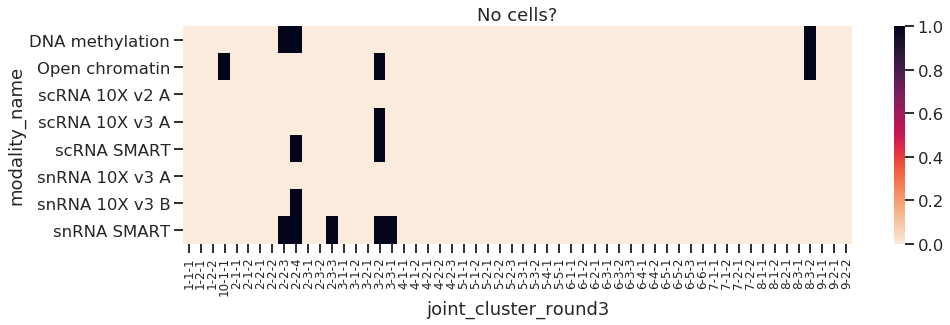

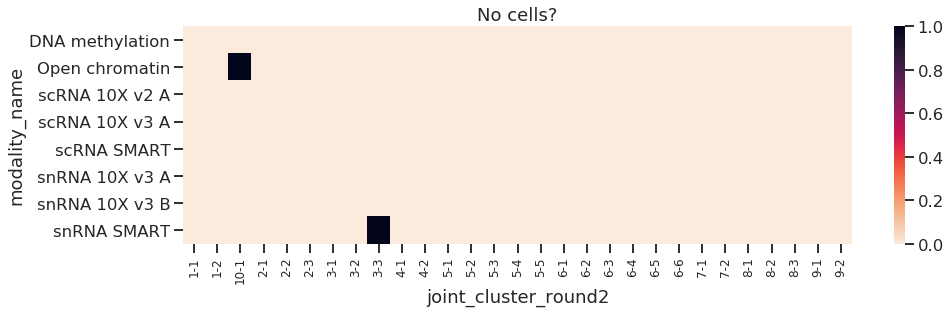

In [12]:
mat = df_info.groupby(['modality_name', 'joint_cluster_round3']).size().unstack().isnull()
fig, ax = plt.subplots(figsize=(15, 4))
sns.heatmap(mat, xticklabels=True, ax=ax, cmap='rocket_r')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_title('No cells?')
fout = output_figures.format('level3_no_cell', 'pdf')
fig.savefig(fout)
plt.show()

mat = df_info.groupby(['modality_name', 'joint_cluster_round2']).size().unstack().isnull()
fig, ax = plt.subplots(figsize=(15, 4))
sns.heatmap(mat, xticklabels=True, ax=ax, cmap='rocket_r')
ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
ax.set_title('No cells?')
fout = output_figures.format('level2_no_cell', 'pdf')
fig.savefig(fout)
plt.show()

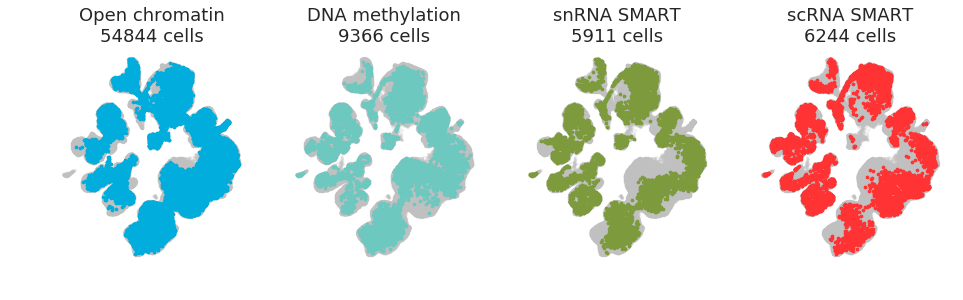

In [13]:
# mods_ordered = ['snmcseq_gene', 'snatac_gene', 
#                  '10x_cells_v3', 'smarter_cells', 
#                 ]
    
n = len(mods_ordered)
nx = n
ny = int((n+nx-1)/nx)
fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
axs = axs.flatten()
for mod, ax in zip(mods_ordered, axs):
    ax.scatter(df_info['tsne_x_joint'].values, 
                df_info['tsne_y_joint'].values, 
                s=3,
                alpha=0.2,
                rasterized=True,
                color='silver')
    ax.scatter(df_info.loc[df_info['modality']==mod, 'tsne_x_joint'].values, 
                df_info.loc[df_info['modality']==mod, 'tsne_y_joint'].values, 
                s=5,
                alpha=1,
                rasterized=True,
                color=settings[mod].color)
    ax.set_title("{}\n{} cells".format(settings[mod].name, len(df_info[df_info['modality']==mod])))
    ax.axis('off')

for ax in axs[n:]:
    ax.axis('off')

fig.savefig(output_figures.format('plot_n0', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

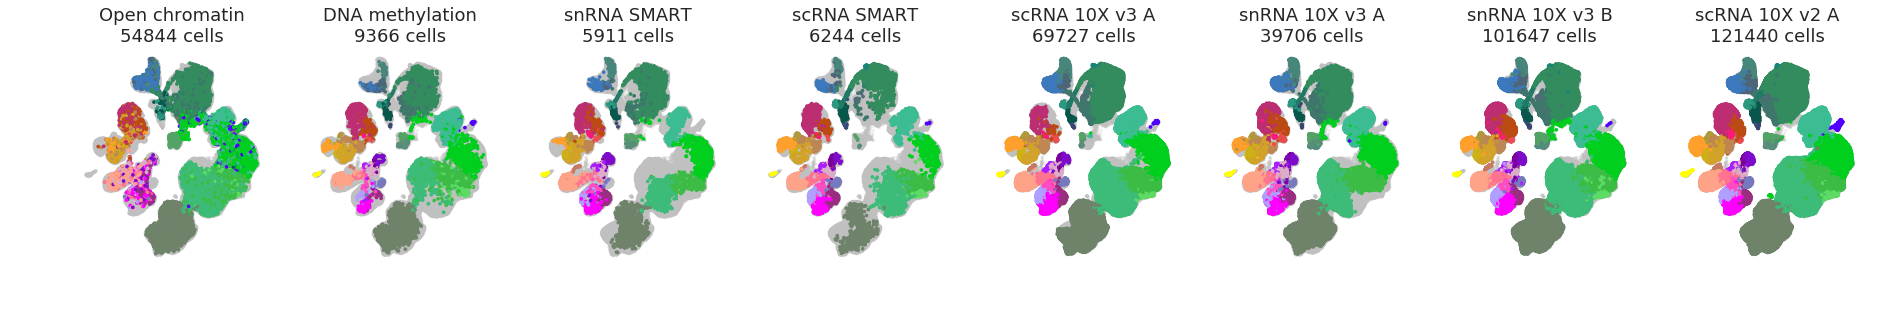

In [119]:
n = len(mods_selected)
nx = 8
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
axs = axs.flatten()
for mod, ax in zip(mods_ordered, axs):
    ax.scatter(df_info['tsne_x_joint'].values, 
                df_info['tsne_y_joint'].values, 
                s=3,
                alpha=0.2,
                rasterized=True,
                color='silver')
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', joint_cluster
    snmcseq_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
                                      t_xlim=None, t_ylim=None,
                                      legend_mode=-1,
                                      rasterized=True,
                                      kw_colors=joint_clst_colors,
                                      s=5,
                                     )
    ax.set_title('{}\n{} cells'.format(settings[mod].name, 
                                       len(df_info.loc[(df_info['modality']==mod)]), 
                                      ))
    ax.axis('off')

for ax in axs[n:]:
    ax.axis('off')

fig.savefig(output_figures.format('plot_n1_nolabel_scf', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

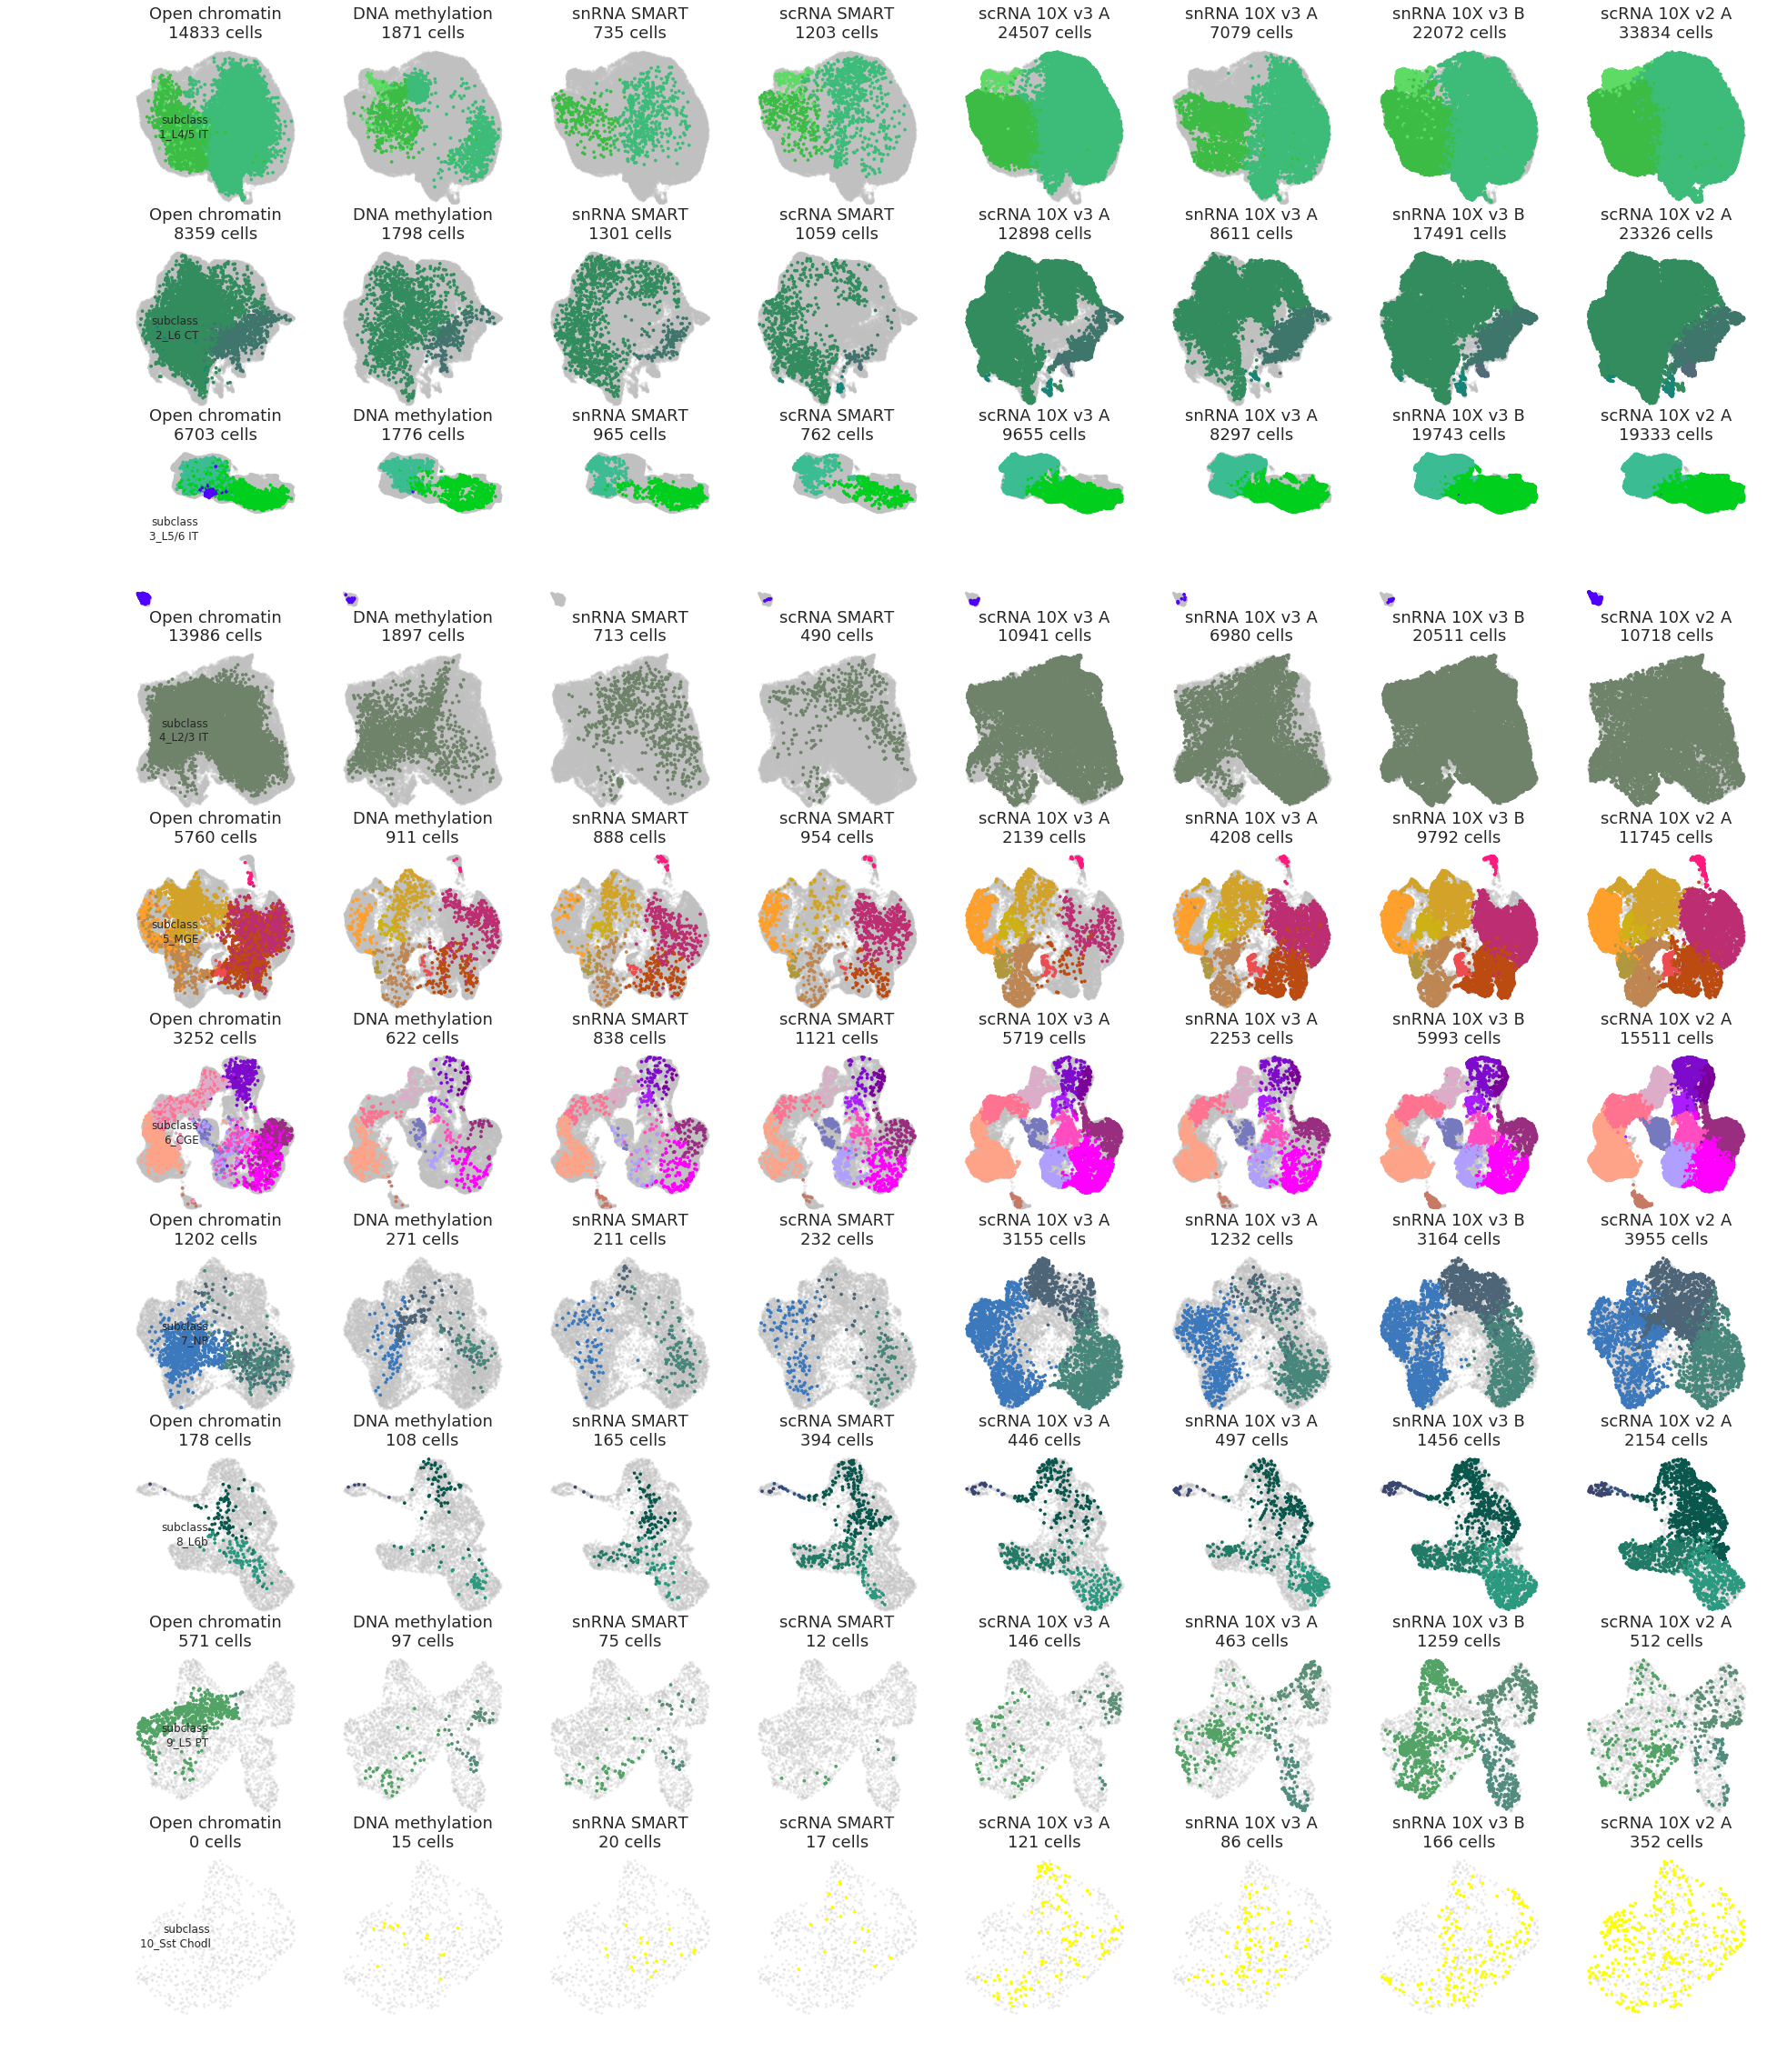

In [120]:
n = len(mods_ordered)
nx = 8
ny = 10

tx, ty, tc = 'tsne_x_joint_sub', 'tsne_y_joint_sub', joint_cluster

fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
for i, subclass in enumerate(subclasses):
    df_info_sub = df_info[df_info['joint_cluster_round1']==subclass]
    for j, mod in enumerate(mods_ordered):
        ax = axs[i, j]
        ax.scatter(df_info_sub[tx].values, 
                   df_info_sub[ty].values, 
                   s=3,
                   alpha=0.2,
                   rasterized=True,
                   color='silver')
        df_info_sub_mod = df_info_sub[df_info_sub['modality']==mod]
        if len(df_info_sub_mod) > 0:
            snmcseq_utils.plot_tsne_labels_ax(df_info_sub_mod, ax, tx, ty, tc, 
                                              t_xlim=None, t_ylim=None,
                                              legend_mode=-1,
                                              rasterized=True,
                                              kw_colors=joint_clst_colors,
                                              s=5,
                                             )
        ax.set_title('{}\n{} cells'.format(settings[mod].name, 
                                           len(df_info_sub_mod), 
                                          ))
        ax.axis('off')
        
        if j == 0:
            text = "subclass\n{}_{}".format(subclass, subclasses_name[subclass])
            pad = 0
            ax.annotate(text, xy=(0, 0.5), 
#                         xytext=(-ax.yaxis.labelpad - pad, 0),
                        xycoords=ax.yaxis.label, 
#                         textcoords='offset points',
                        size='large', ha='right', va='center')

# fig.tight_layout()
fig.savefig(output_figures.format('plot_n1_nolabel_subclasses_scf', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [69]:
f = '/cndd/fangming/CEMBA/data/MOp_all/josh_welch/LIGER_organized_FX2.tsv' 
df_liger_neurons = pd.read_csv(f, sep='\t').rename(columns={'level1_UMAP_1': 'UMAP_1', 
                                                            'level1_UMAP_2': "UMAP_2", 
                                                            "level2_cluster": "cluster",
                                                           })
print(df_liger_neurons.shape)
df_liger_neurons.head()

(408736, 13)


cell    UMAP_1     UMAP_2  level2_UMAP_1  level2_UMAP_2  \
0  SM-GE653_S113_E1-50 -3.164615  12.190200       4.718955      -2.380108   
1  SM-GE653_S117_E1-50 -3.395991  11.764448       2.380869      -2.322626   
2  SM-GE653_S118_E1-50 -2.278710  12.773043       6.417862      -1.314918   
3  SM-GE653_S120_E1-50 -2.899099  12.395375       5.662322      -2.015199   
4  SM-GE653_S122_E1-50 -3.567551  11.620143       2.055580      -3.102450   

   level1_cluster cluster        modality modality_name  \
0              10   cge_5  smarter_nuclei  SMART nuclei   
1              10   cge_5  smarter_nuclei  SMART nuclei   
2               8   cge_5  smarter_nuclei  SMART nuclei   
3              10   cge_5  smarter_nuclei  SMART nuclei   
4              10   cge_5  smarter_nuclei  SMART nuclei   

  single_modality_cluster single_modality_annot       annot    color  
0                       2         Lamp5 Egln3_2  Lamp5 Pax6  #DDACC9  
1                       2         Lamp5 Egln3_2  Lamp5 Pax6  #DDACC9  
2                       9             Vip Cbln4  Lamp5 Pax6  #DDACC9  
3                       2         Lamp5 Egln3_2  Lamp5 Pax6  #DDACC9  
4                       2         Lamp5 Egln3_2  Lamp5 Pax6  #DDACC9

In [70]:
f = '/cndd/fangming/CEMBA/data/MOp_all/josh_welch/LIGER_non_neuron_organized_FX2.tsv' 
df_liger_nonneurons = pd.read_csv(f, sep='\t').rename(columns={"level2_cluster": "cluster",
                                                              })
print(df_liger_nonneurons.shape)
df_liger_nonneurons.head()

(86293, 7)


cell    UMAP_1    UMAP_2       cluster           annot  \
0  SM-GE64U_S119_E1-50 -6.489569  3.124291  non_neuron_0  Oligo Opalin_2   
1  SM-GE63Z_S046_E1-50 -6.252966  2.816719  non_neuron_0  Oligo Opalin_2   
2  SM-GE63Z_S063_E1-50 -3.739112  4.154798  non_neuron_0  Oligo Opalin_2   
3  SM-GE63Z_S138_E1-50 -4.678784  1.695413  non_neuron_0  Oligo Opalin_2   
4  SM-GE63Z_S147_E1-50 -2.644890  3.455592  non_neuron_0  Oligo Opalin_2   

     color        modality  
0  #6CA491  smarter_nuclei  
1  #6CA491  smarter_nuclei  
2  #6CA491  smarter_nuclei  
3  #6CA491  smarter_nuclei  
4  #6CA491  smarter_nuclei

In [112]:
df_liger_nonneurons['modality'].unique()

array(['smarter_nuclei', 'smarter_cells', '10x_nuclei_v3_macosko',
       '10x_nuclei_v3', '10x_cells_v2', '10x_cells_v3', 'snatac_gene'], dtype=object)

In [91]:
f = '/cndd/fangming/CEMBA/data/MOp_all/josh_welch/LIGER_non_neuron_organized_annot_FX2.tsv'
df_annot = pd.read_csv(f, sep="\t") 
joint_annot = df_annot.set_index('cluster').rename(columns={'color': 'cluster_color'})
joint_clst_colors_nonneurons = joint_annot['cluster_color'].to_dict()
joint_clst_colors_nonneurons

{'non_neuron_0': '#6CA491',
 'non_neuron_1': '#8D7C5D',
 'non_neuron_10': '#535946',
 'non_neuron_11': '#6CA491',
 'non_neuron_12': '#535944',
 'non_neuron_13': '#8BA38D',
 'non_neuron_14': '#332F26',
 'non_neuron_2': '#6E7C6F',
 'non_neuron_3': '#2E3E39',
 'non_neuron_4': '#474662',
 'non_neuron_5': '#8D6A62',
 'non_neuron_6': '#5A503F',
 'non_neuron_7': '#697255',
 'non_neuron_8': '#5E8A79',
 'non_neuron_9': '#A6906F'}

In [92]:
f = '/cndd/fangming/CEMBA/data/MOp_all/josh_welch/LIGER_neuron_organized_annot_FX2.tsv'
df_annot = pd.read_csv(f, sep="\t") 
joint_annot = df_annot.set_index('cluster').rename(columns={'color': 'cluster_color'})
joint_clst_colors_neurons = joint_annot['cluster_color'].to_dict()
joint_clst_colors_neurons

{'cge_0': '#FFA388',
 'cge_1': '#FF8C97',
 'cge_10': '#B3128A',
 'cge_11': '#AB1DFF',
 'cge_12': '#DDACC9',
 'cge_13': '#9440F3',
 'cge_14': '#C77963',
 'cge_15': '#FF00FF',
 'cge_16': '#FFA388',
 'cge_2': '#FF4DC1',
 'cge_3': '#FF00FF',
 'cge_4': '#992E81',
 'cge_5': '#F08E98',
 'cge_6': '#7779BF',
 'cge_7': '#FF00FF',
 'cge_8': '#7A0099',
 'cge_9': '#B09FFF',
 'it_0': '#2EB934',
 'it_1': '#52B8AA',
 'it_10': '#2EB934',
 'it_2': '#52B8AA',
 'it_3': '#58D2C1',
 'it_4': '#81791F',
 'it_5': '#2EB934',
 'it_6': '#52B4B8',
 'it_7': '#2EB934',
 'it_8': '#52B8AA',
 'it_9': '#2EB934',
 'mge_0': '#9C4165',
 'mge_1': '#BC2D71',
 'mge_10': '#ED4C50',
 'mge_11': '#FFFF00',
 'mge_12': '#F4358B',
 'mge_13': '#8A2B1A',
 'mge_14': '#D2A328',
 'mge_2': '#CDB115',
 'mge_3': '#FF9F2C',
 'mge_4': '#BC2C41',
 'mge_5': '#802600',
 'mge_6': '#784F14',
 'mge_7': '#BE8652',
 'mge_8': '#FFB307',
 'mge_9': '#E62A5D',
 'non_it_0': '#338C5E',
 'non_it_1': '#338C5E',
 'non_it_10': '#338C5E',
 'non_it_11': '#0D5D7E

In [93]:
mods_ordered = [
    'smarter_cells',
    '10x_cells_v3',
    '10x_cells_v2', 
    'smarter_nuclei',
    '10x_nuclei_v3',
    '10x_nuclei_v3_macosko',
    'snatac_gene',
    'snmcseq_gene',
    ]

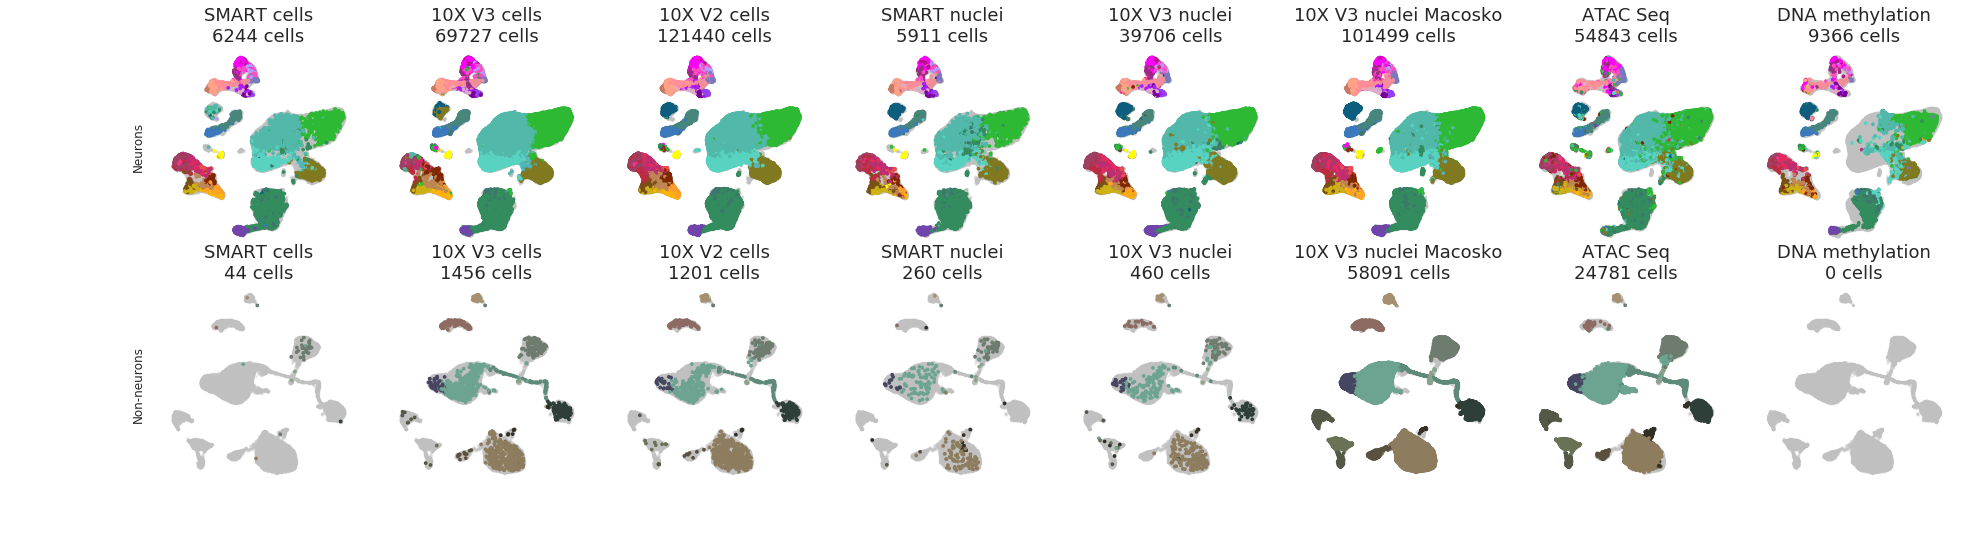

In [111]:
n = len(mods_ordered)
nx = 8
ny = 2 

tx, ty, tc = 'UMAP_1', 'UMAP_2', 'cluster'

fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
ax_row = axs[0,:]
for i, (mod, ax) in enumerate(zip(mods_ordered, ax_row)):
    ax.scatter(df_liger_neurons[tx].values, 
                df_liger_neurons[ty].values, 
                s=3,
                alpha=0.2,
                rasterized=True,
                color='silver')
    to_plot = df_liger_neurons[df_liger_neurons['modality']==mod]
    if len(to_plot) > 0:
        snmcseq_utils.plot_tsne_labels_ax(to_plot, ax, tx, ty, tc, 
                                          t_xlim=None, t_ylim=None,
                                          legend_mode=-1,
                                          rasterized=True,
                                          kw_colors=joint_clst_colors_neurons,
                                          s=5,
                                         )
    ax.set_title('{}\n{} cells'.format(settings[mod].name, 
                                       len(to_plot), 
                                      ))
    ax.axis('off')
    if i == 0:
        text = "Neurons"
        pad = 70
        ax.annotate(text, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                rotation=90,
                size='large', ha='right', va='center')
    
ax_row = axs[1,:]
for i, (mod, ax) in enumerate(zip(mods_ordered, ax_row)):
    ax.scatter(df_liger_nonneurons[tx].values, 
                df_liger_nonneurons[ty].values, 
                s=3,
                alpha=0.2,
                rasterized=True,
                color='silver')
    to_plot = df_liger_nonneurons[df_liger_nonneurons['modality']==mod]
    if len(to_plot) > 0:
        snmcseq_utils.plot_tsne_labels_ax(to_plot, ax, tx, ty, tc, 
                                          t_xlim=None, t_ylim=None,
                                          legend_mode=-1,
                                          rasterized=True,
                                          kw_colors=joint_clst_colors_nonneurons,
                                          s=5,
                                         )
    ax.set_title('{}\n{} cells'.format(settings[mod].name, 
                                       len(to_plot), 
                                      ))
    ax.axis('off')
    if i == 0:
        text = "Non-neurons"
        pad = 70
        ax.annotate(text, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                rotation=90,
                size='large', ha='right', va='center')

fig.savefig(output_figures.format('plot_n1_nolabel_liger', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

In [127]:
df_liger_neurons.head()
df_new = df_liger_neurons[df_liger_neurons['cluster'].str.contains(r'^it_')]
print(df_new.shape)
df_new.head()

(235557, 13)


cell    UMAP_1    UMAP_2  level2_UMAP_1  level2_UMAP_2  \
12635  SM-GE653_S123_E1-50  8.699857  3.034634      -2.406309      -7.297477   
12636  SM-GE653_S127_E1-50  9.595199  2.401746      -1.585638      -9.614527   
12637  SM-GE653_S132_E1-50  8.788064  5.791589      -1.189827      -6.115875   
12638  SM-GE653_S133_E1-50  7.571135  1.862523      -3.073609      -7.283985   
12639  SM-GE64R_S097_E1-50  6.128006  3.170595      -3.113934      -5.091500   

       level1_cluster cluster        modality modality_name  \
12635               1    it_0  smarter_nuclei  SMART nuclei   
12636               1    it_0  smarter_nuclei  SMART nuclei   
12637               1    it_0  smarter_nuclei  SMART nuclei   
12638               1    it_0  smarter_nuclei  SMART nuclei   
12639               1    it_0  smarter_nuclei  SMART nuclei   

      single_modality_cluster single_modality_annot        annot    color  
12635                      24               L2/3 IT  L2/3 IT (1)  #6F836B  
12636                      24               L2/3 IT  L2/3 IT (1)  #6F836B  
12637                      24               L2/3 IT  L2/3 IT (1)  #6F836B  
12638                      24               L2/3 IT  L2/3 IT (1)  #6F836B  
12639                      24               L2/3 IT  L2/3 IT (1)  #6F836B

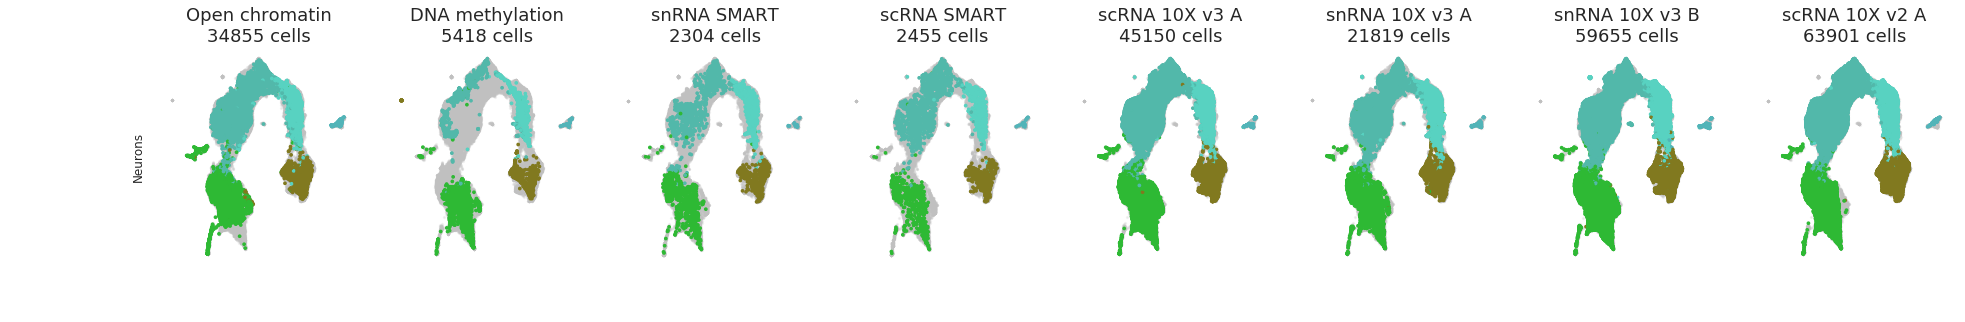

In [128]:
n = len(mods_ordered)
nx = 8
ny = 1 

tx, ty, tc = 'level2_UMAP_1', 'level2_UMAP_2', 'cluster'

fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
for i, (mod, ax) in enumerate(zip(mods_ordered, axs)):
    ax.scatter(df_new[tx].values, 
                df_new[ty].values, 
                s=3,
                alpha=0.2,
                rasterized=True,
                color='silver')
    to_plot = df_new[df_new['modality']==mod]
    if len(to_plot) > 0:
        snmcseq_utils.plot_tsne_labels_ax(to_plot, ax, tx, ty, tc, 
                                          t_xlim=None, t_ylim=None,
                                          legend_mode=-1,
                                          rasterized=True,
                                          kw_colors=joint_clst_colors_neurons,
                                          s=5,
                                         )
    ax.set_title('{}\n{} cells'.format(settings[mod].name, 
                                       len(to_plot), 
                                      ))
    ax.axis('off')
    if i == 0:
        text = "Neurons"
        pad = 70
        ax.annotate(text, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                rotation=90,
                size='large', ha='right', va='center')
    
fig.savefig(output_figures.format('plot_n1_nolabel_liger_it', 'pdf'), bbox_inches='tight', dpi=300)
plt.show()

## add color by cell types; add color by 

In [11]:
def plot_1():
    from matplotlib.gridspec import GridSpec

    sample_n = min(len(df_info), 20000)
    n_resolutions = len(resolutions)
    fig = plt.figure(figsize=(8*2,6*2))
    gs = GridSpec(2, n_resolutions)

    ax = fig.add_subplot(gs[0, :])
    kw_colors = {settings[mod].name: settings[mod].color for mod in mods_ordered}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      kw_colors=kw_colors,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')

    layouts = [(1, i) for i in range(n_resolutions)]
    for resolution, layout in zip(resolutions, layouts):
        ax = fig.add_subplot(gs[layout[0], layout[1]])
        tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster_joint_r{}'.format(resolution)
        snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                          legend_mode=-1,
                                          sample_n=sample_n,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_aspect('equal')
        ax.axis('off')
        ax.set_title('{} joint clusters (r={})'.format(len(df_info[tc].unique()), resolution))

    fig.tight_layout()
    fig.savefig(output_figures.format(1, 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()

In [12]:
def plot_1_single(kw_colors='', show_labels=False, output=''):
    """plot umap cluster 
    """
    fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', joint_cluster
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                         #  legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=kw_colors,
                                      legend_mode=-1,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')
    if show_labels:
        for clst, centroid in centroids['joint'].iterrows():
            facecolor='white'
            ax.text(centroid.values[0], 
                    centroid.values[1], 
                    str(clst)+'_'+joint_annot.loc[clst, 'annot'],
                    color='black', 
                    bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                    fontsize=10,
                   )

    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()
        
def plot_2_single(output=''):
    """Plot umap - modality
    """
    fig, ax = plt.subplots(1, 1, figsize=(8*1,8*1))
    kw_colors = {settings[mod].name: settings[mod].color for mod in mods_selected}
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'modality_name'
    legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
    snmcseq_utils.plot_tsne_labels_ax(df_info, ax, tx, ty, tc, 
                                      legend_kws=legend_kws,
                                      sample_n=sample_n,
                                      legend_size=30,
                                      rasterized=True,
                                      kw_colors=kw_colors,
                                      s=2,
                                     )
    ax.set_aspect('equal')
    ax.axis('off')

    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()

def plot_3(output='', 
           show_labels=False):
    """Plot umap - cluster - each modality
    """
    n = len(mods_selected)
    nx = 3
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(6*nx,6*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', 'cluster'

    for ax, mod in zip(axs, mods_selected):
        snmcseq_utils.plot_tsne_labels_ax(df_info[df_info['modality']==mod], ax, tx, ty, tc, 
                                          sample_n=sample_n,
                                          legend_mode=-1,
                                          rasterized=True,
                                          s=2,
                                         )
        ax.set_title('{} ({} clusters)'.format(settings[mod].name, len(df_info.loc[df_info['modality']==mod, tc].unique())))
    
        if show_labels:
            for clst, centroid in centroids[mod].iterrows():
                facecolor='white'
                ax.text(centroid.values[0], 
                        centroid.values[1], 
                        clst,
                        color='black', 
                        bbox=dict(facecolor=facecolor, alpha=0.3, edgecolor='black', boxstyle='round,pad=0.1'),
                        fontsize=10,
                       )
        ax.set_aspect('equal')
        ax.axis('off')
    for ax in axs[n:]:
        ax.axis('off')


    fig.subplots_adjust(wspace=0.05, hspace=0.05)
    fig.savefig(output, bbox_inches='tight', dpi=300)
    plt.show()


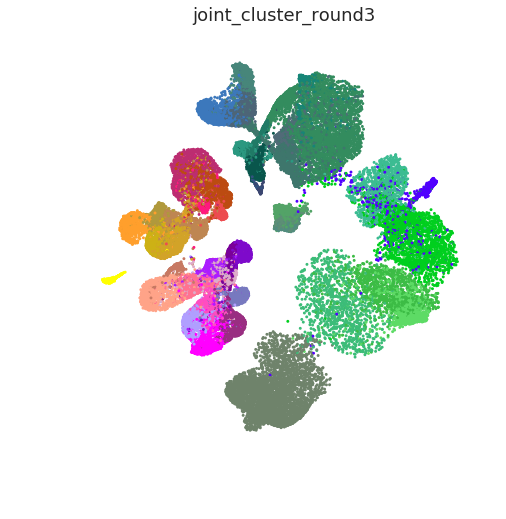

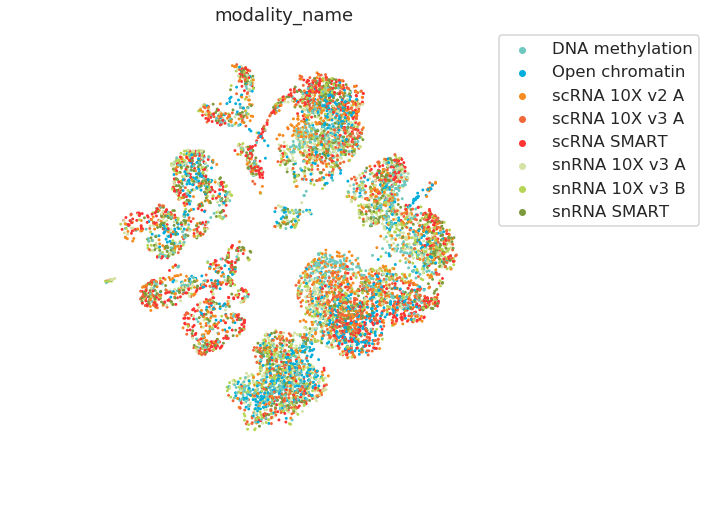

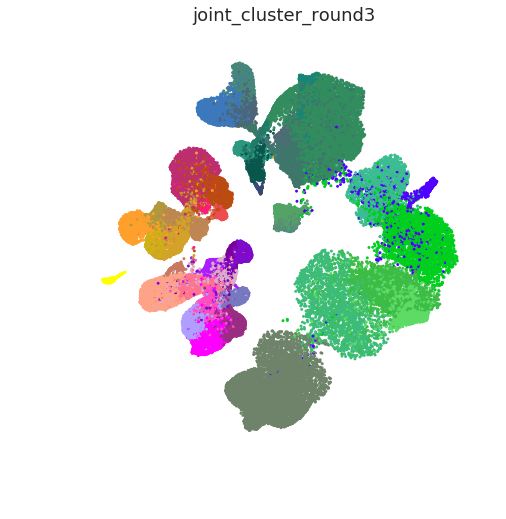

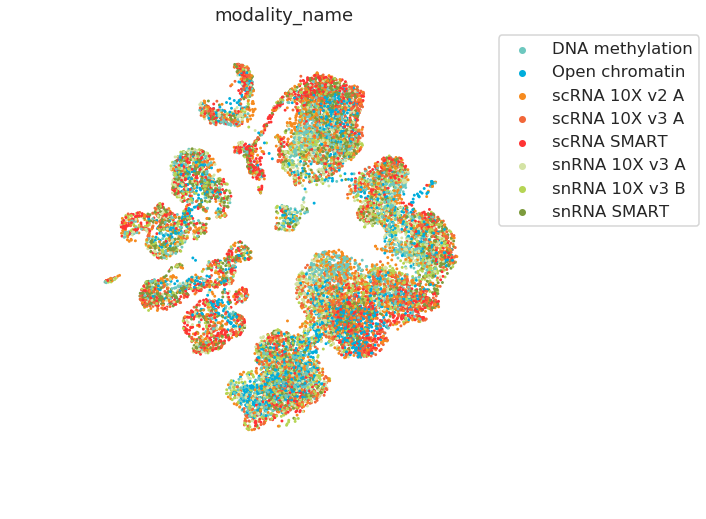

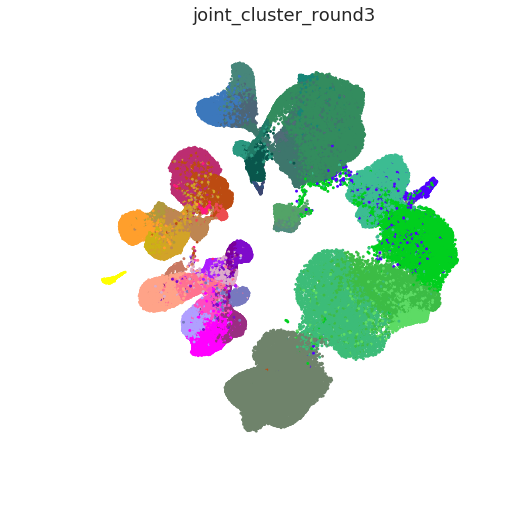

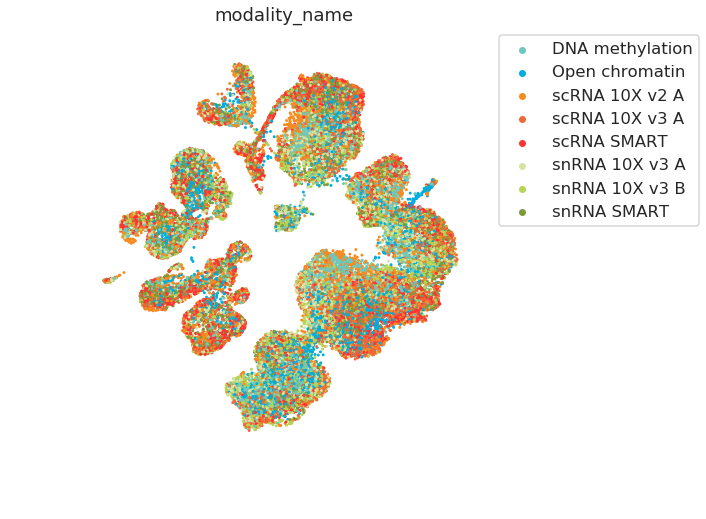

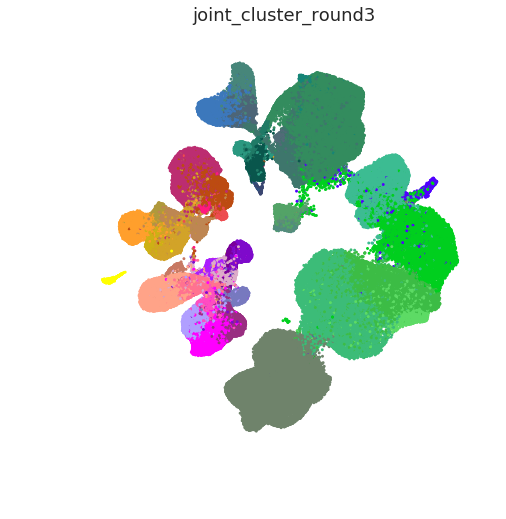

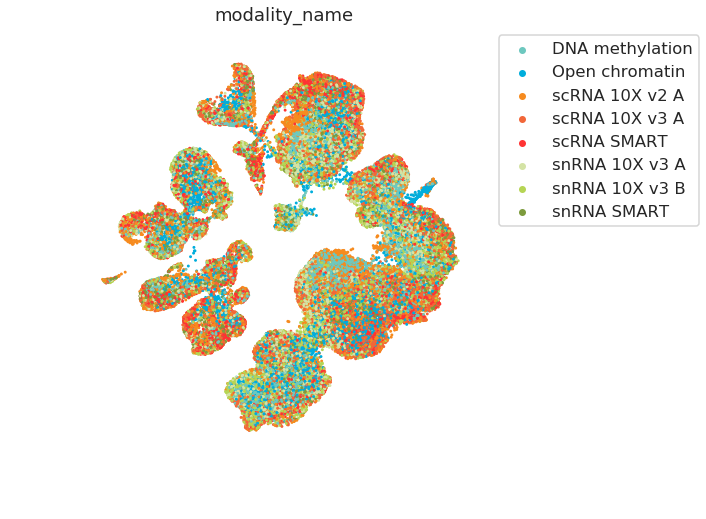

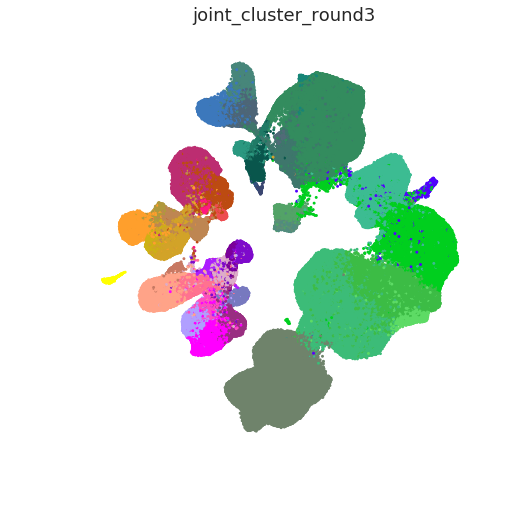

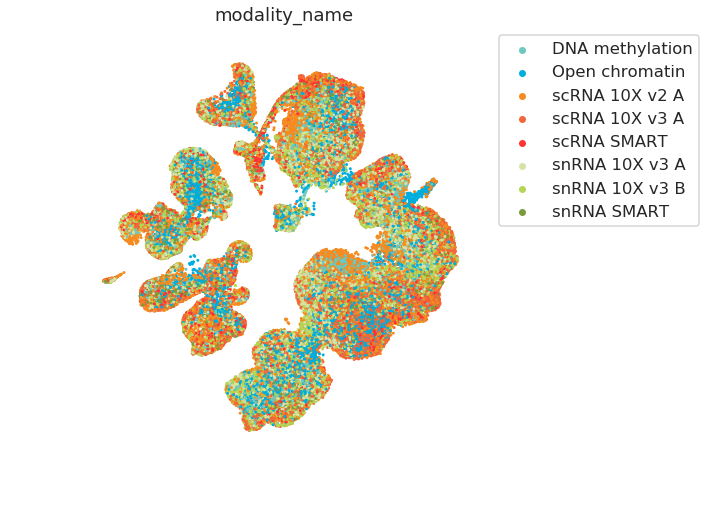

In [205]:
# sample_n = 20000
sample_n = 10000
# umap cluster
for sample_n in [1000, 2000, 5000, 10000, 20000]:
#     plot_1_single(joint_clst_colors, show_labels=True, output=output_figures.format('round2_1-label', 'pdf'))
    plot_1_single(joint_clst_colors, show_labels=False, output=output_figures.format('round2_1-nolabel_{}'.format(sample_n), 'pdf'))
    plot_2_single(output=output_figures.format('round2_2-nolabel_{}'.format(sample_n), 'pdf'))

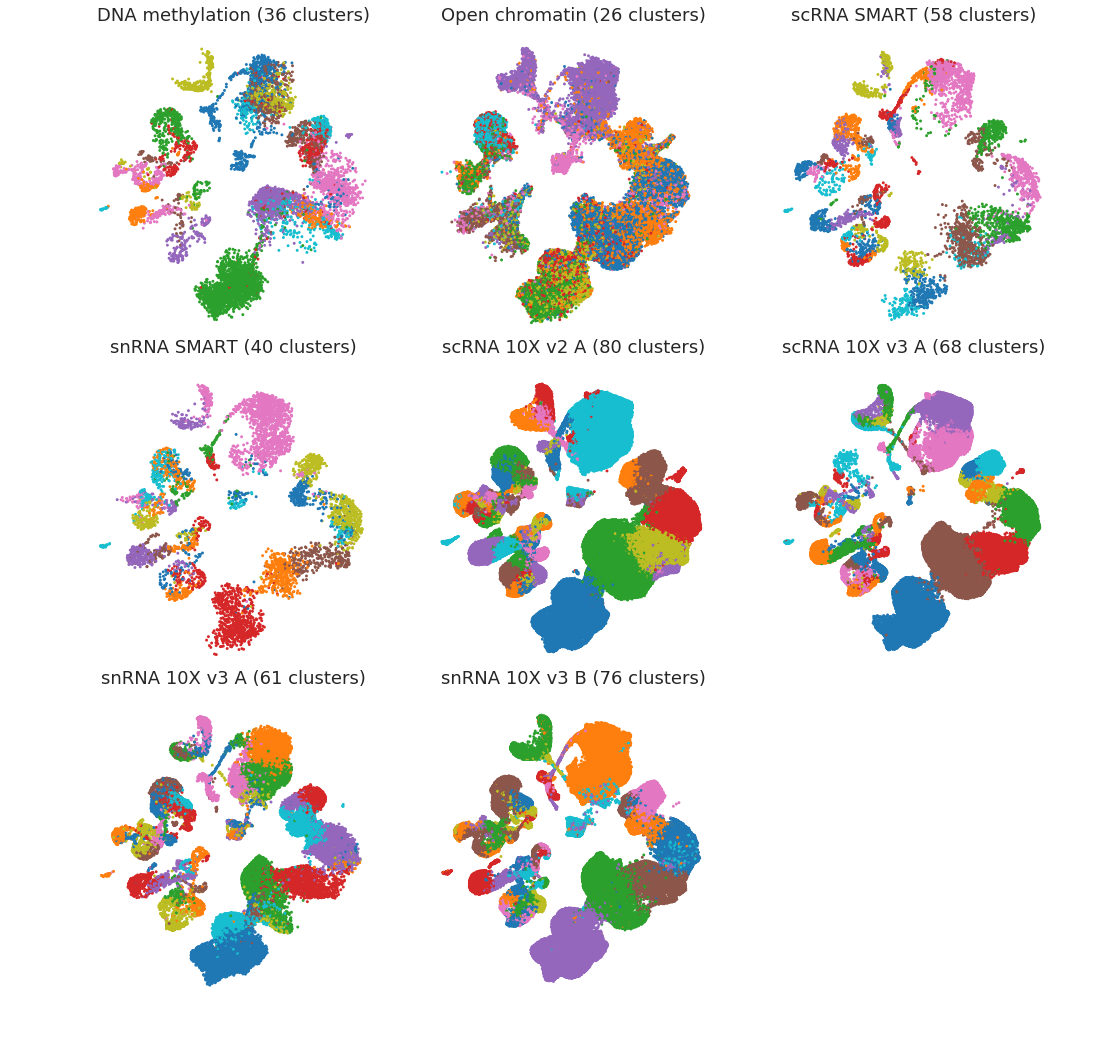

In [16]:
# umap modality
# plot_3(show_labels=True, output=output_figures.format('3-label', 'pdf'))
plot_3(show_labels=False, output=output_figures.format('3-nolabel', 'pdf'))

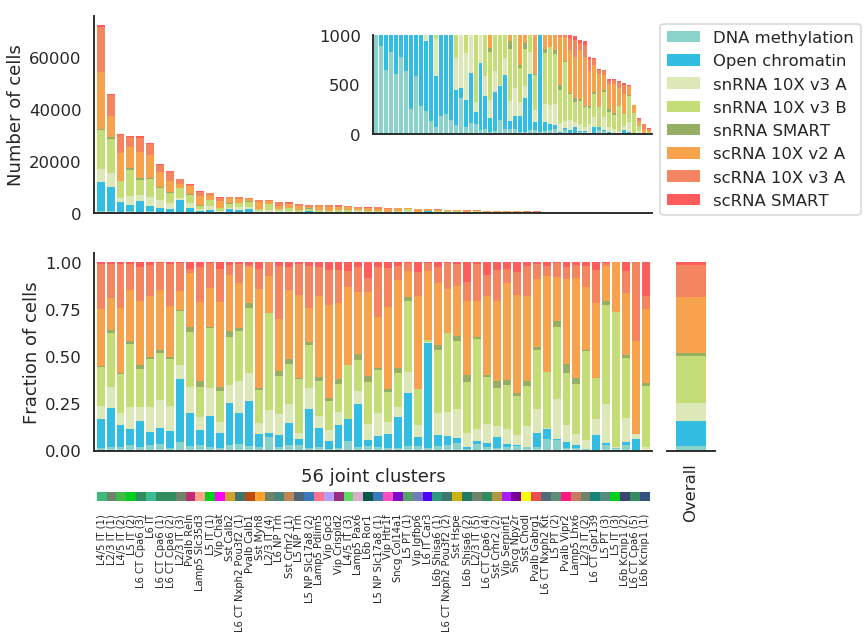

In [13]:
clsts_order = df_info.groupby(joint_cluster).size().sort_values(ascending=False).index.values
mods_ordered_new = [
    'smarter_cells',
    '10x_cells_v3',
    '10x_cells_v2',
    'smarter_nuclei',
    '10x_nuclei_v3_macosko',
    '10x_nuclei_v3',
    'snatac_gene',
    'snmcseq_gene',
][::-1]

# histograms
with sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    fig, axs = plt.subplots(2, 1, figsize=(10*1,4*2))
    axs = axs.flatten()
    ax = axs[0]
    legend = True
    colors = [mod_colors[key] for key in mods_ordered_new] # this controls mod_colors
    (hist[mods_ordered_new].rename(index=mod_names, columns=mod_names)
                             .reindex(clsts_order)
                             .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax,
                                       legend=legend,
                                       color=colors, # this controls color order
                                     )
    )
    sns.despine(ax=ax)
    ax.set_ylabel('Number of cells')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    axs[0].legend(bbox_to_anchor=(1, 1))
    
    num_th = 1000
    legend = False
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+0.5*width, left_y+0.4*height, 0.5*(width), 0.5*height))
    (hist[mods_ordered_new].rename(index=mod_names, columns=mod_names)
#                              [hist.sum(axis=1)<num_th]
                             .reindex(clsts_order)
                             .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax,
                                       legend=legend,
                                       color=colors, # this controls color order
                                     )
    )
    sns.despine(ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels([])
    ax.set_ylim([0, num_th])
    
    ax = axs[1]
    (hist_frac[mods_ordered_new].rename(index=mod_names, columns=mod_names)
                             .reindex(clsts_order)
                             .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                                       color=colors, # this controls color order
                                     )
    )
    sns.despine(ax=ax)
    ax.set_ylabel('Fraction of cells')
    ax.set_xlabel('{} joint clusters'.format(len(hist)))
    ax.set_xticklabels([])
    
#     ax = fig.add_axes([.95, .5, .05, .4])
    left_x, left_y, width, height = ax.get_position().bounds
    ax = fig.add_axes((left_x+width+0.2*(1-(left_x+width)), left_y, 0.3*(1-width), height))
    ((hist_mod/hist_mod.sum()).loc[mods_ordered_new].to_frame().T.rename({0: 'Overall'}, axis=0)
                              .plot.bar(stacked=True, width=0.8, alpha=0.8, ax=ax, legend=False, 
                                       color=colors, # this controls color order
                                       )
    )
    sns.despine(left=True, ax=ax)
    ax.set_ylabel('')
    ax.set_yticklabels([])
    
    ax = fig.add_axes((left_x, left_y-0.7*left_y, width, 0.05*height))
    to_plot = pd.DataFrame()
    to_plot['color'] = joint_annot.loc[hist.reindex(clsts_order).index, 'cluster_color']
    to_plot['annot'] = joint_annot.loc[hist.reindex(clsts_order).index, 'annot']
    to_plot['bar'] = 1
    (to_plot['bar'].plot.bar(stacked=True, width=1, 
                     alpha=1, 
                      ax=ax, 
                      legend=False, 
                     color=to_plot['color'].values, 
                     )
    )
    sns.despine(left=True, bottom=True, ax=ax)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_xticklabels(to_plot['annot'].values, fontsize=10)
    ax.set_yticks([])
    
    
#     fig.tight_layout()
    fig.savefig(output_figures.format('round3_4', 'pdf'), bbox_inches='tight')
    plt.show()

In [16]:
def plot_5(base_cluster, joint_cluster, 
           mods_ordered=mods_ordered,
           output='',
          ):
#     mods_ordered = mods_ordered_new
    nx = len(mods_ordered)
    ny = 2
    heatmap_kws = {
        'xticklabels': False, 
        'yticklabels': False,
        'vmin': 0, 
        'vmax': 1,
        'cmap': 'Reds',
    }

    cbar_kws = {
        'orientation': 'vertical', 
        'label': 'Fraction of cells',
    }

    with sns.plotting_context('talk'):
        fig, axs = plt.subplots(ny, nx, figsize=(3*nx, 3*ny))
        axs = axs.T
        cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
        njoint_clusters = len(df_info[joint_cluster].unique())
        for i, (mod, ax) in enumerate(zip(mods_ordered[::-1], axs)):
            if mod == 'snmcseq_gene':
                conf_mat = pd.crosstab(df_info.loc[((df_info['modality']==mod) & (df_info[base_cluster]!='Outlier')), base_cluster], 
                                       df_info.loc[((df_info['modality']==mod) & (df_info[base_cluster]!='Outlier')), joint_cluster],
                                      )
            else:
                conf_mat = pd.crosstab(df_info.loc[df_info['modality']==mod, base_cluster], 
                                       df_info.loc[df_info['modality']==mod, joint_cluster],
                                      )
            # normalize each joint cluster
            conf_mat_njoint = conf_mat.divide(conf_mat.sum(axis=0), axis=1)
            # normalize each orig cluster
            conf_mat_norig = conf_mat.divide(conf_mat.sum(axis=1), axis=0)

            # plot normalized by joint 
            if i == 0:
                # order both row and col
                _X = conf_mat_njoint
                _rX, ri, rc = snmcseq_utils.diag_matrix(_X.values, _X.index.values, _X.columns.values, threshold=0.3)
                _rX = pd.DataFrame(_rX, index=ri, columns=rc)
                g = sns.heatmap(_rX.T, 
                            cbar=True,
                            cbar_kws=cbar_kws,
                            cbar_ax=cbar_ax,
                            ax=ax[0],
                            **heatmap_kws,
                           )
                g.axes.set_title('{}\n{} clusters'.format(mod, _rX.shape[0]))
                g.axes.set_ylabel('Row normalized\n{} joint clusters'.format(njoint_clusters))

                order_joint = _rX.columns.values # Will be fixed for all integrated clusters 
                order_orig = _rX.index.values # Will be fixed for the mod clusters  
            else:
                # order just row (orig)
                _X = conf_mat_njoint.loc[:, order_joint].fillna(0)
                _rX, ri, rc = snmcseq_utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
                _rX = pd.DataFrame(_rX, index=ri, columns=rc)
                g = sns.heatmap(_rX.T, 
                            cbar=False,
                            ax=ax[0],
                            **heatmap_kws,
                           )
                g.axes.set_title('{}\n{} clusters'.format(settings[mod].name, _rX.shape[0]))
                g.axes.set_ylabel('')

                order_orig = _rX.index.values # Will be fixed for the mod clusters  
            # bounding box
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)
                spine.set_color(settings[mod].color)
    #             spine.set_linewidth(3)

            # plot normalized by orig (according to the axis of normalized by joint) 
            _X = conf_mat_norig.loc[order_orig, order_joint].fillna(0)
            g = sns.heatmap(_X.T, 
                        cbar=False,
                        ax=ax[1],
                        **heatmap_kws,
                       )
            if i == 0:
                g.axes.set_xlabel('')
                g.axes.set_ylabel('Col normalized\n{} joint clusters'.format(njoint_clusters))
            else:
                g.axes.set_xlabel('')
                g.axes.set_ylabel('')
            # bounding box
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)
                spine.set_color(settings[mod].color)
    #             spine.set_linewidth(3)

        plt.subplots_adjust(hspace=0.05, wspace=0.05)
        fig.savefig(output, bbox_inches='tight')
        plt.show()

In [35]:
def plot_6(base_cluster, joint_cluster, 
           mods_ordered=mods_ordered,
           output='',
           threshold=0.3,
           perfig_size=3,
          ):
#     mods_ordered = mods_ordered_new
    nx = len(mods_ordered)
    ny = 2
    heatmap_kws = {
        'vmin': 0, 
        'vmax': 1,
        'cmap': 'Reds',
    }

    cbar_kws = {
        'orientation': 'vertical', 
        'label': 'Fraction of cells',
    }

    with sns.plotting_context('talk'):
        fig, axs = plt.subplots(ny, nx, figsize=(perfig_size*nx, perfig_size*ny))
        axs = axs.T # iterate col by col
        cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
        njoint_clusters = len(df_info[joint_cluster].unique())
        for i, (mod, ax) in enumerate(zip(mods_ordered[::-1], axs)):
            # one col
            if mod == 'snmcseq_gene':
                conf_mat = pd.crosstab(df_info.loc[((df_info['modality']==mod) & (df_info[base_cluster]!='Outlier')), base_cluster], 
                                       df_info.loc[((df_info['modality']==mod) & (df_info[base_cluster]!='Outlier')), joint_cluster],
                                      )
            else:
                conf_mat = pd.crosstab(df_info.loc[df_info['modality']==mod, base_cluster], 
                                       df_info.loc[df_info['modality']==mod, joint_cluster],
                                      )
            # normalize each joint cluster
            conf_mat_njoint = conf_mat.divide(conf_mat.sum(axis=0), axis=1)
            # normalize each orig cluster
            conf_mat_norig = conf_mat.divide(conf_mat.sum(axis=1), axis=0)

            # first of a col--plot normalized by joint 
            if i == 0:
                # order both row and col
                _X = conf_mat_njoint
                _rX, ri, rc = snmcseq_utils.diag_matrix(_X.values, _X.index.values, _X.columns.values, 
                                                        threshold=threshold)
                _rX = pd.DataFrame(_rX, index=ri, columns=rc)
                g = sns.heatmap(_rX.T, 
                            cbar=True,
                            cbar_kws=cbar_kws,
                            cbar_ax=cbar_ax,
                            xticklabels=False,
                            yticklabels=True,
                            ax=ax[0],
                            **heatmap_kws,
                           )
                g.axes.set_title('{}\n{} clusters'.format(mod, _rX.shape[0]))
                g.axes.set_ylabel('Row normalized\n{} joint clusters'.format(njoint_clusters))

                order_joint = _rX.columns.values # Will be fixed for all integrated clusters 
                order_orig = _rX.index.values # Will be fixed for the mod clusters  
            else:
                # order just row (orig)
                _X = conf_mat_njoint.loc[:, order_joint].fillna(0)
                _rX, ri, rc = snmcseq_utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
                _rX = pd.DataFrame(_rX, index=ri, columns=rc)
                g = sns.heatmap(_rX.T, 
                            cbar=False,
                            xticklabels=False,
                            yticklabels=False,
                            ax=ax[0],
                            **heatmap_kws,
                           )
                g.axes.set_title('{}\n{} clusters'.format(settings[mod].name, _rX.shape[0]))
                g.axes.set_ylabel('')

                order_orig = _rX.index.values # Will be fixed for the mod clusters  
            # bounding box
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)
                spine.set_color(settings[mod].color)
    #             spine.set_linewidth(3)

            # second of a col--plot normalized by orig (according to the axis of normalized by joint) 
            if i == 0:
                yticklabels = True
            else:
                yticklabels = False
                
            _X = conf_mat_norig.loc[order_orig, order_joint].fillna(0)
            g = sns.heatmap(_X.T, 
                        cbar=False,
                        xticklabels=True,
                        yticklabels=yticklabels,
                        ax=ax[1],
                        **heatmap_kws,
                       )
            if i == 0:
                g.axes.set_xlabel('')
                g.axes.set_ylabel('Col normalized\n{} joint clusters'.format(njoint_clusters))
            else:
                g.axes.set_xlabel('')
                g.axes.set_ylabel('')
            # bounding box
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)
                spine.set_color(settings[mod].color)
    #             spine.set_linewidth(3)

        plt.subplots_adjust(hspace=0.05, wspace=0.05)
        fig.savefig(output, bbox_inches='tight')
        plt.show()

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


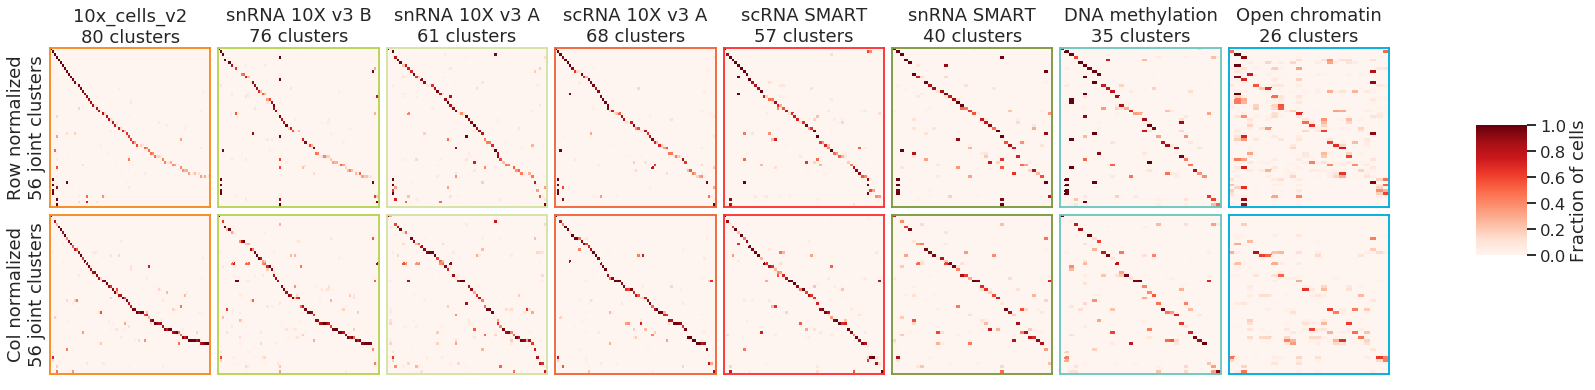

In [15]:
# confusion matrix
base_cluster = 'cluster'
plot_5(base_cluster, joint_cluster, 
       output=output_figures.format(5, 'pdf'),
       )

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


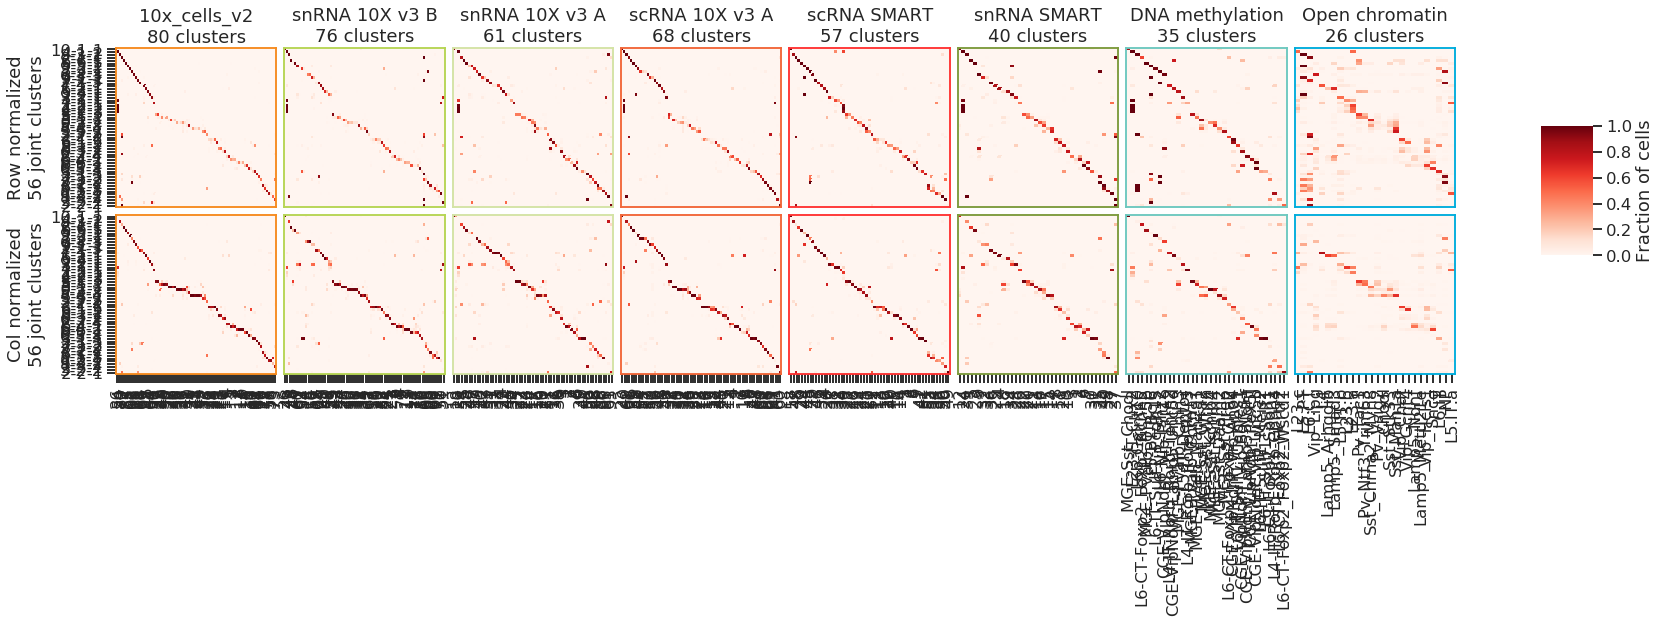

In [39]:
# confusion matrix
base_cluster = 'cluster'
plot_6(base_cluster, joint_cluster, 
       output=output_figures.format(5, 'pdf'),
       threshold=0.9,
       )

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


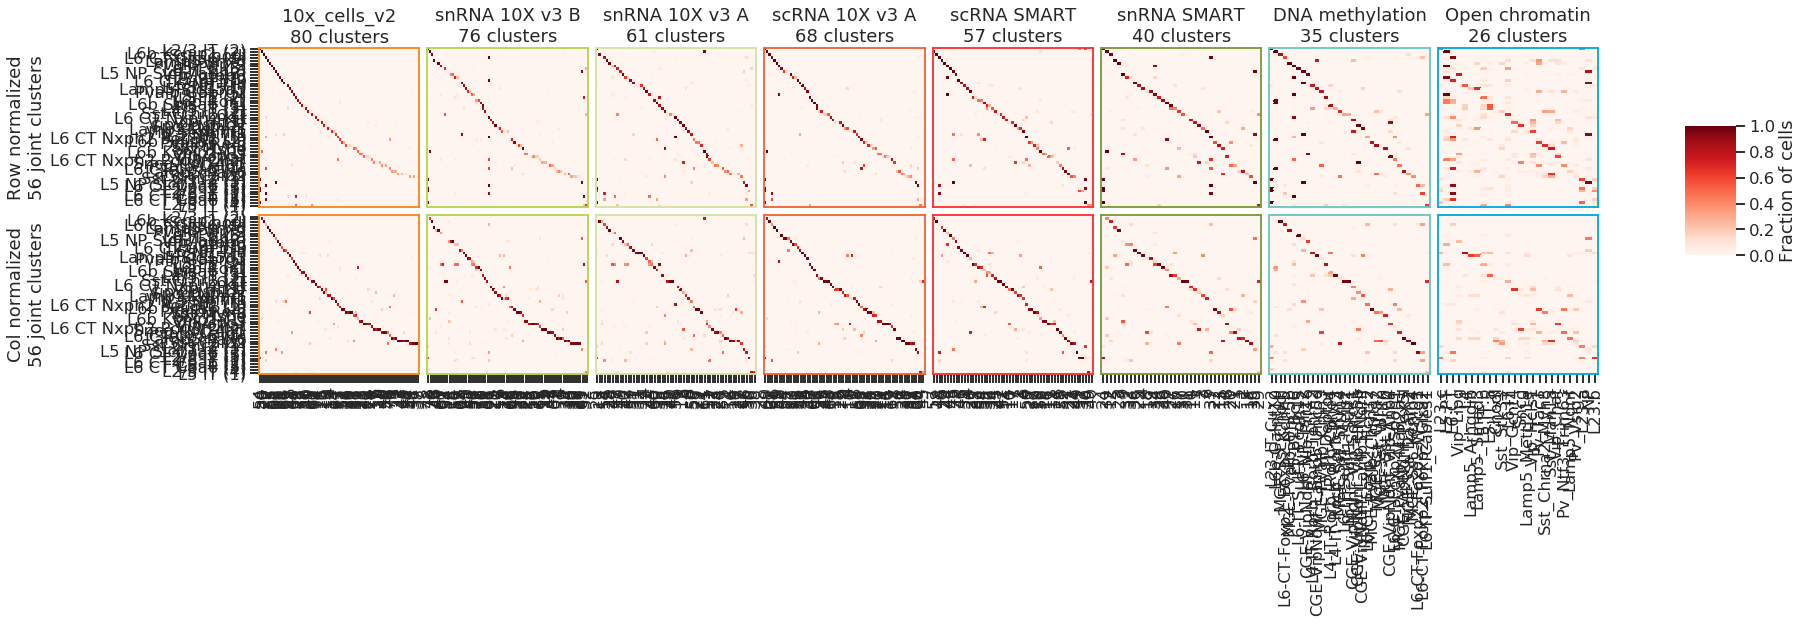

In [49]:
# confusion matrix
base_cluster = 'cluster'
plot_6(base_cluster, joint_cluster+'_anno', 
       output=output_figures.format(5, 'pdf'),
       threshold=0.05,
       )

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


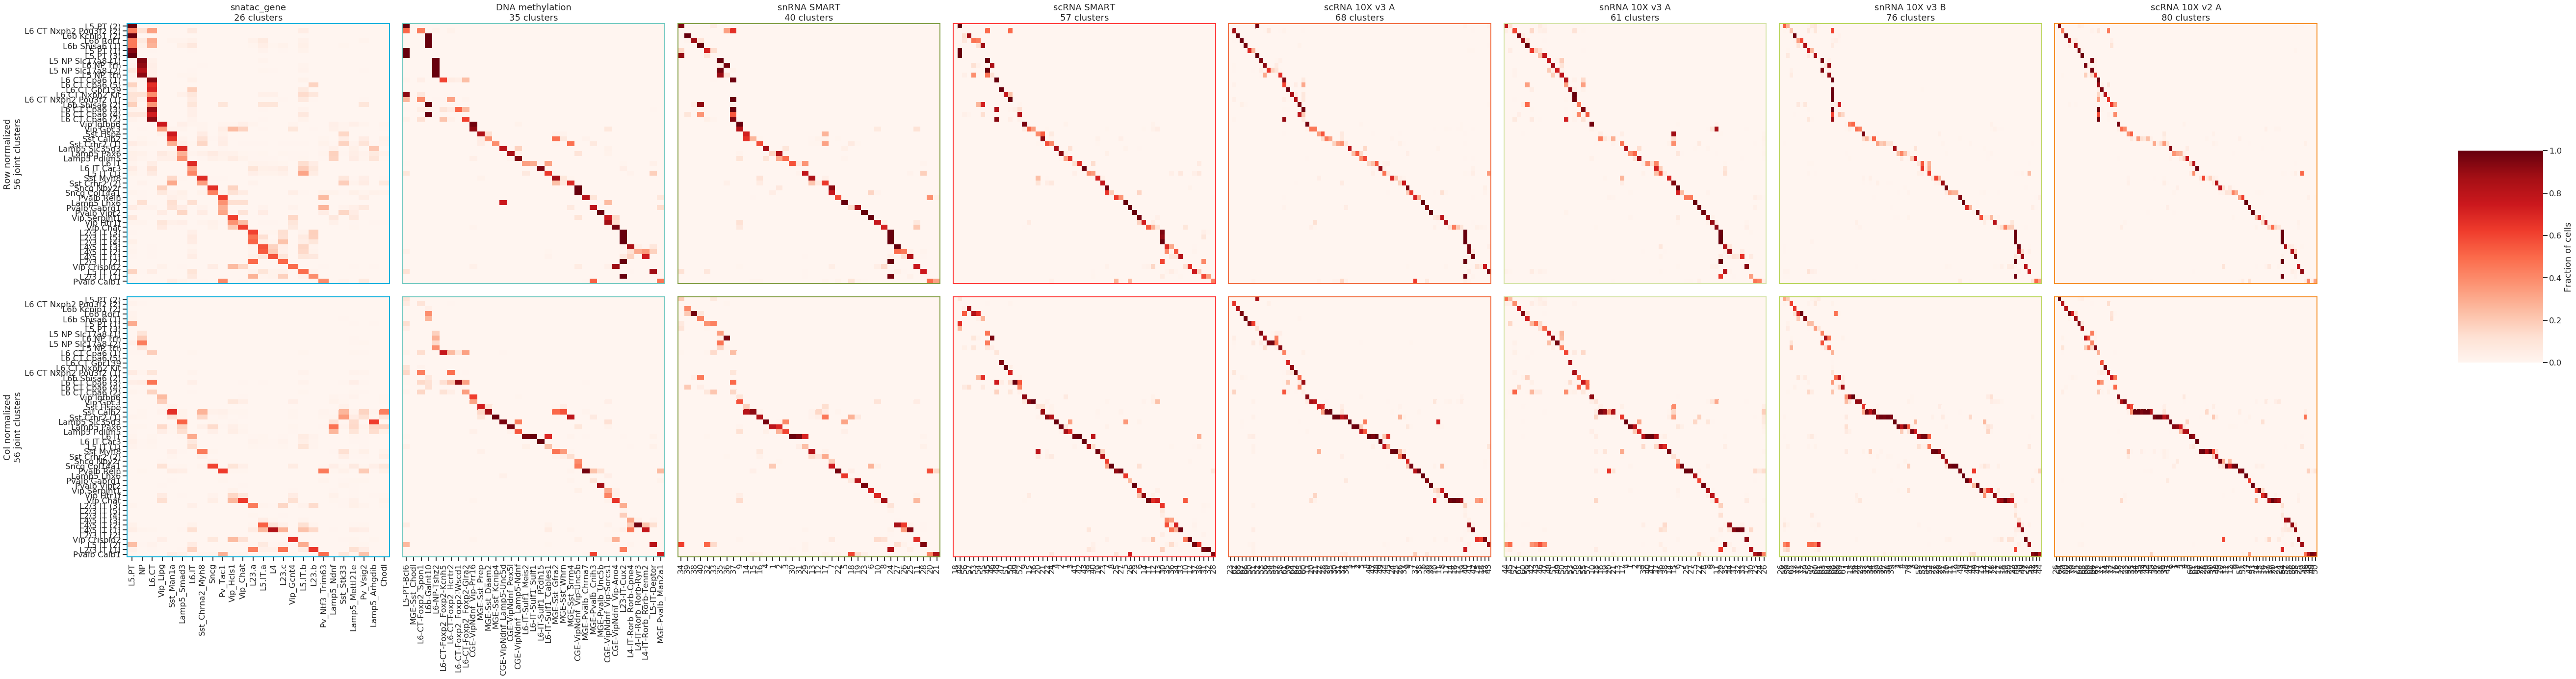

In [51]:
# confusion matrix
base_cluster = 'cluster'
plot_6(base_cluster, joint_cluster+'_anno', 
        mods_ordered=mods_ordered[::-1],
       output=output_figures.format("confusion_matrices", 'pdf'),
#        threshold=0.05,
       perfig_size=10,
       )

/cndd/fangming/venvs/conda_dobro/lib/python3.6/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


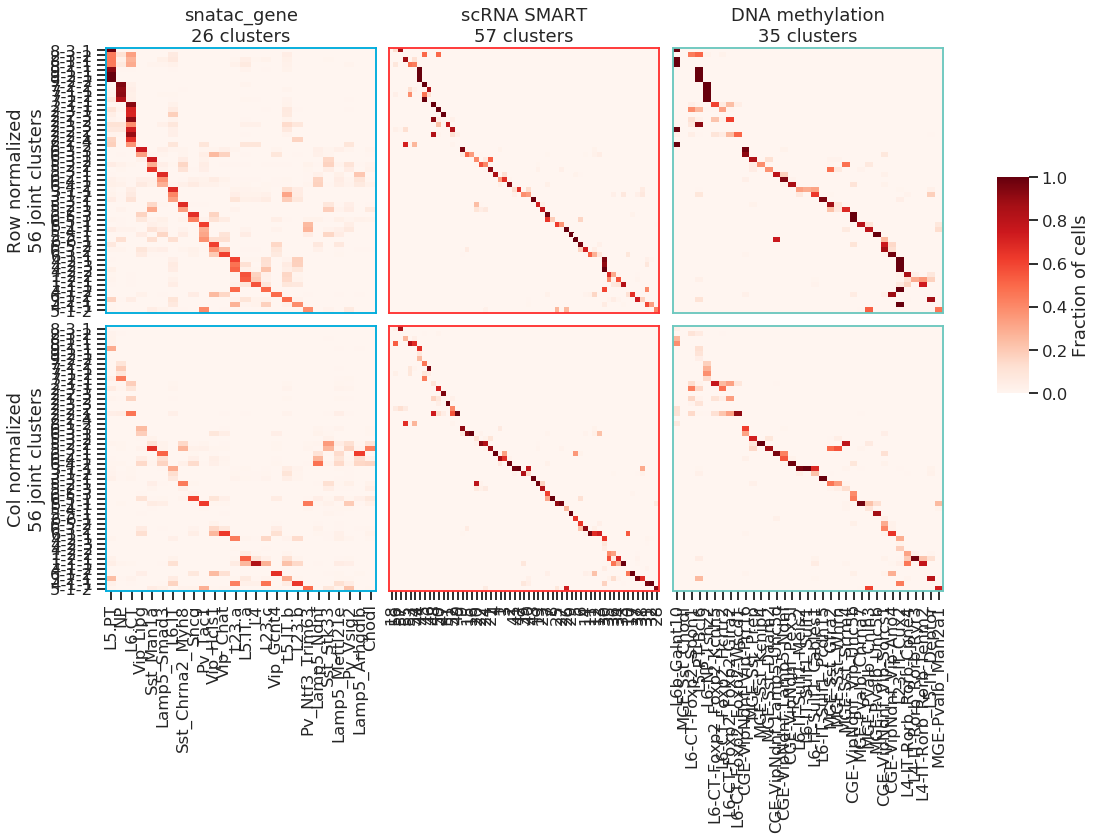

In [42]:
# confusion matrix

with sns.plotting_context("paper"):
    base_cluster = 'cluster'
    plot_6(base_cluster, joint_cluster, 
           mods_ordered=['snmcseq_gene', 'smarter_cells', 'snatac_gene',],
           output=output_figures.format(6, 'pdf'),
           threshold=0.2,
           perfig_size=5,
           )

#### Heatmap of correlation of cluster centroids 
- imputed data

In [59]:
mods_included = mods_selected
mod_reference = features_selected[0]
cells_all = np.load(output_cells_all, allow_pickle=True)
imputed_data = np.load(output_imputed_data_format.format(mod_reference), allow_pickle=True)

joint_cluster = 'joint_cluster_round1'
f_cluster_annot = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_fig4_scf_annotation_round1.tsv'
df_annot = pd.read_csv(f_cluster_annot, sep="\t") 
joint_annot = df_annot.set_index('cluster_id_iterative').rename(columns={'color': 'cluster_color', 
                                                                         'annotation_curated': 'annot',
                                                                        })
# get uniq colors for joint clusters  
joint_clst_colors = joint_annot['cluster_color'].to_dict()

# cluster centroids of imputed data
cluster_centroids = collections.OrderedDict()
for (clst, mod), df_sub in df_info.groupby([joint_cluster, 'modality']):
    if mod in mods_included:
        cells_sub = df_sub.index.values
        cells_sub_idx = snmcseq_utils.get_index_from_array(cells_all, cells_sub)
        if mod not in cluster_centroids.keys():
            cluster_centroids[mod] = {}
        cluster_centroids[mod][clst] = np.ravel(imputed_data[cells_sub_idx,:].mean(axis=0))

# # Saving the objects:
# with open(output_cluster_centroids, 'wb') as f: 
#     pickle.dump((
#                 cluster_centroids
#                 ), f)

In [63]:
mods_included = [
 'smarter_cells',
 '10x_cells_v3',
 '10x_cells_v2',
 'smarter_nuclei',
 '10x_nuclei_v3_macosko',
 '10x_nuclei_v3',
 'snatac_gene',
 'snmcseq_gene',
]

cluster_centroids_df = collections.OrderedDict()
for mod in mods_selected:
    if mod in mods_included:
        cluster_centroids_df[mod] = pd.DataFrame(cluster_centroids[mod])

# each modality and cluster
uniq_clusters = df_info[joint_cluster].unique()
corr_grand_clusters = np.hstack([[mod+'_'+str(clst)
                                for clst in cluster_centroids_df[mod].columns.values]
                                for mod in mods_included])

# grand correlation matrix
corr_grand = {}
for i, mod_x in enumerate(mods_included):
    for j, mod_y in enumerate(mods_included):
        if j >= i:
            gene_x = cluster_centroids_df[mod_x].index.values
            gene_y = cluster_centroids_df[mod_y].index.values
            gene_common = np.intersect1d(gene_x, gene_y)
            _x = (cluster_centroids_df[mod_x].loc[gene_common]).rank(axis=0).T.values
            _y = (cluster_centroids_df[mod_y].loc[gene_common]).rank(axis=0).T.values
            corr = np.corrcoef(_x, _y)[:len(_x), len(_x):]
            corr_grand[(i, j)] = corr
            if j != i:
                corr_grand[(j, i)] = corr.T
                
corr_grand = np.hstack([np.vstack([
                    corr_grand[(i, j)] for i in range(len(mods_included))
                    ])
                for j in range(len(mods_included))
                ])

# labels
# corr_grand_label = np.hstack([[str(clst) + "_" + str(joint_annot.loc[clst, 'annot'])
#                                for clst in cluster_centroids_df[mod].columns.values] 
#                             for mod in mods_included
#                             ])
corr_grand_label = np.hstack([[str(joint_annot.loc[clst, 'annot'])
                               for clst in cluster_centroids_df[mod].columns.values] 
                            for mod in mods_included
                            ])
corr_grand_clsts = np.hstack([cluster_centroids_df[mod].columns.values
                            for mod in mods_included
                            ])
corr_grand_mods = np.hstack([
                            [mod]*len(cluster_centroids_df[mod].columns.values) for mod in mods_included
                            ])

# colors
corr_grand_mod_colors = np.array([settings[mod].color for mod in corr_grand_mods])
corr_grand_clst_colors = np.array([joint_clst_colors[clst] for clst in corr_grand_clsts])

In [81]:
uniq_clusters
uniq_clusters_ordered = [
    10, 6, 5, 7, 9, 8, 2, 3, 1, 4, 
]
uniq_clusters = uniq_clusters_ordered

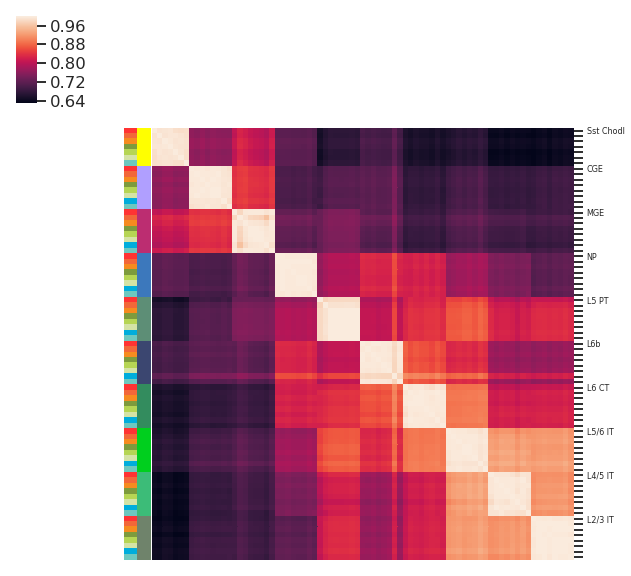

In [84]:
mat = corr_grand
Z = sch.linkage(mat, method='average')
dn = sch.dendrogram(Z, no_plot=True)

# g = sns.clustermap(mat[dn['leaves'],:][:,dn['leaves']], 
#                    row_cluster=False, col_cluster=False,
#                    row_colors=[corr_grand_mod_colors[dn['leaves']], 
#                                corr_grand_clst_colors[dn['leaves']], 
#                               ], 
#                    yticklabels=snmcseq_utils.dedup_array_elements(corr_grand_label[dn['leaves']]),
#                    xticklabels=[],
# #                    figsize=(8, 12),
#                   )

# reorder
orders = np.hstack([[mod+"_"+str(clst)
                               for clst in cluster_centroids_df[mod].columns.values] 
                            for mod in mods_included
                            ])
new_orders = np.ravel(np.vstack([[mod+"_"+str(clst) if int(clst) in cluster_centroids_df[mod].columns.values else ''
                               for clst in uniq_clusters] 
                            for mod in mods_included
                            ]).T
                     )
new_orders = [x for x in new_orders if x]
idx_reorder = snmcseq_utils.get_index_from_array(orders, new_orders)
g = sns.clustermap(mat[idx_reorder,:][:,idx_reorder], 
                   row_cluster=False, col_cluster=False,
                   row_colors=[corr_grand_mod_colors[idx_reorder], 
                               corr_grand_clst_colors[idx_reorder], 
                              ], 
                   yticklabels=snmcseq_utils.dedup_array_elements(corr_grand_label[idx_reorder]),
                   xticklabels=[],
                  )


g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=8)
g.savefig(output_figures.format('round0_8_dataset_heatmap', 'pdf'), bbox_inches='tight')
plt.show()

## Heatmap2 

In [16]:
# output_cells_all
cells_files = np.sort(glob.glob('/cndd/fangming/CEMBA/data/MOp_all/results_final/pcX/round1/cells*'))
imputed_data_files = np.sort(glob.glob('/cndd/fangming/CEMBA/data/MOp_all/results_final/pcX/round1/pcX*'))
celltypes = [file.split('sub')[1][:-4] for file in cells_files]


joint_cluster = 'joint_cluster_round3'
f_cluster_annot = '/cndd/fangming/CEMBA/data/MOp_all/results_final/miniatlas_fig4_scf_annotation_round3.tsv'
df_annot = pd.read_csv(f_cluster_annot, sep="\t") 
joint_annot = df_annot.set_index('cluster_id_iterative').rename(columns={'color': 'cluster_color', 
                                                                         'annotation_curated': 'annot',
                                                                        })
# get uniq colors for joint clusters  
joint_clst_colors = joint_annot['cluster_color'].to_dict()

1 merging...
1 formating...
1 sch clustering...
1 plotting...


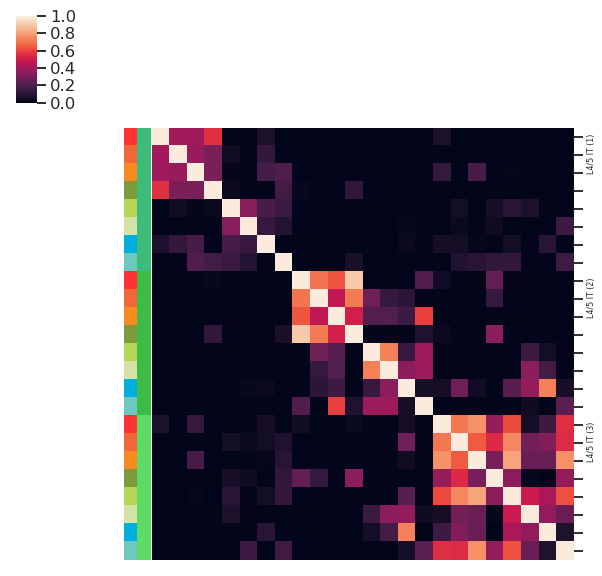

10 merging...
10 skipping...
2 merging...
2 formating...
2 sch clustering...
2 plotting...


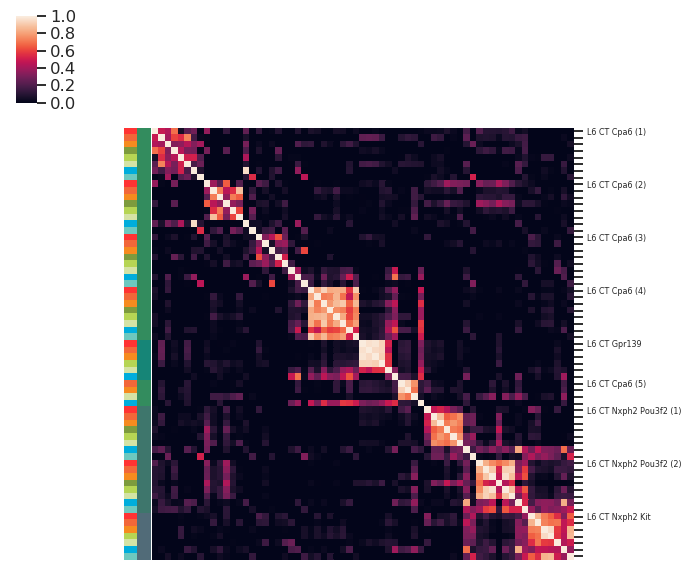

3 merging...
3 formating...
3 sch clustering...
3 plotting...


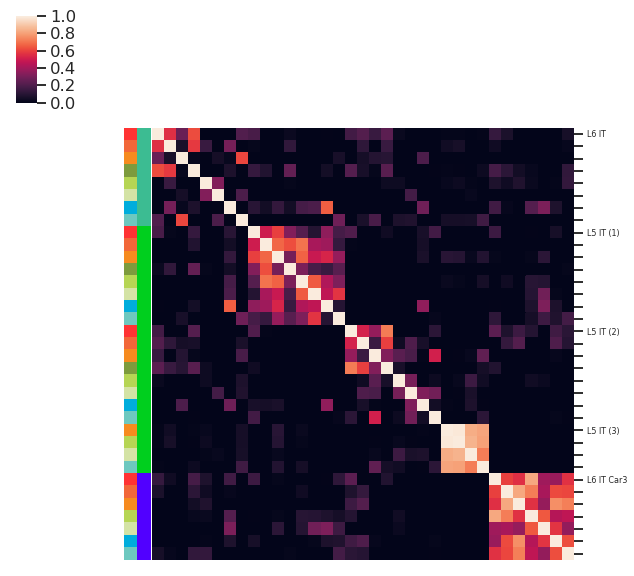

4 merging...
4 formating...
4 sch clustering...
4 plotting...


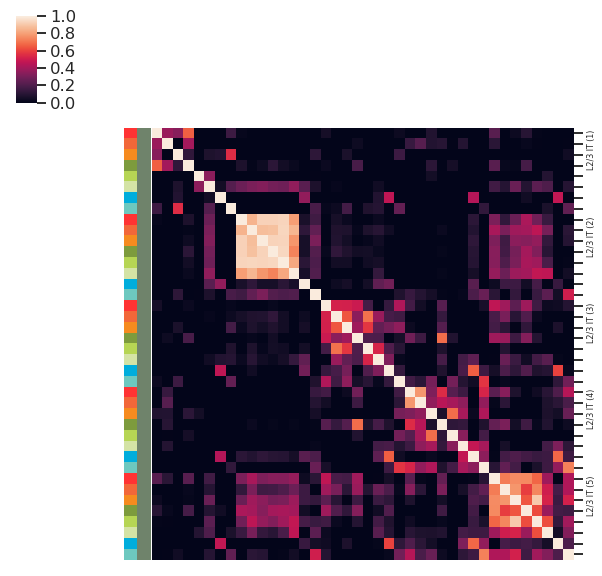

5 merging...
5 formating...
5 sch clustering...
5 plotting...


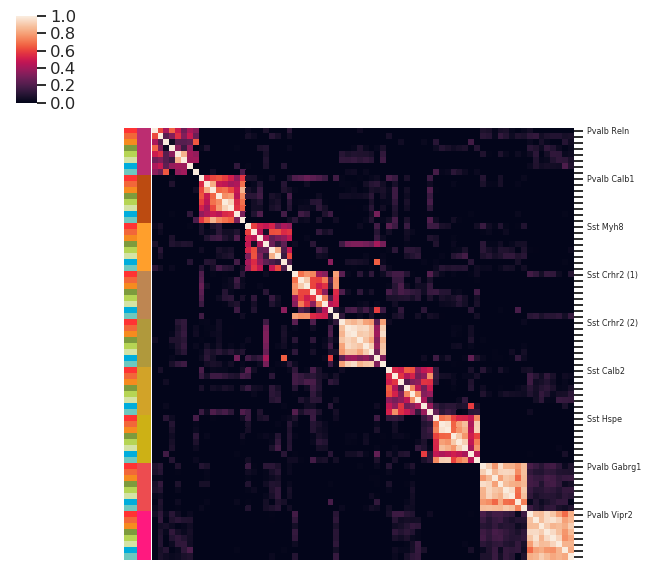

6 merging...
6 formating...
6 sch clustering...
6 plotting...


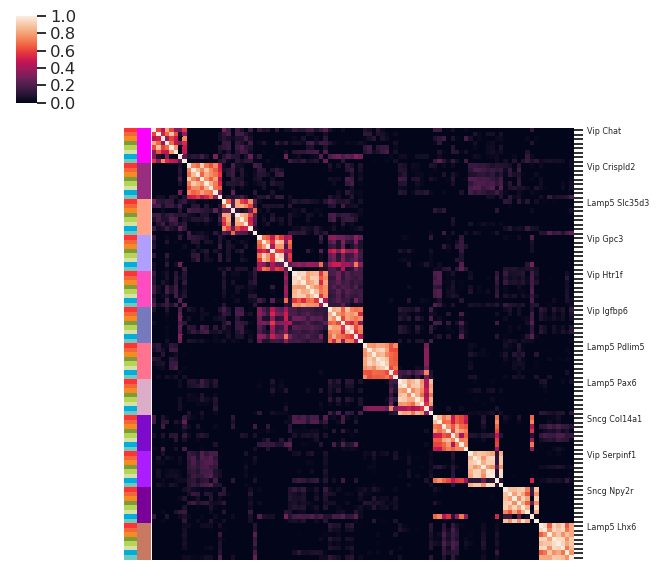

7 merging...
7 formating...
7 sch clustering...
7 plotting...


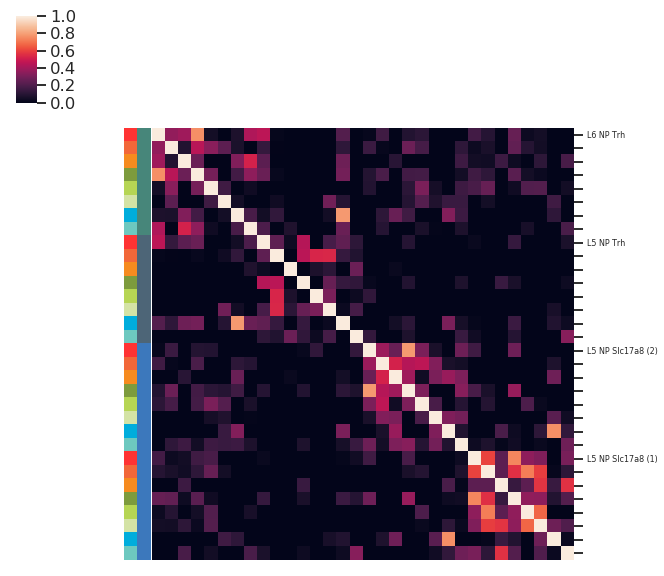

8 merging...
8 formating...
8 sch clustering...
8 plotting...


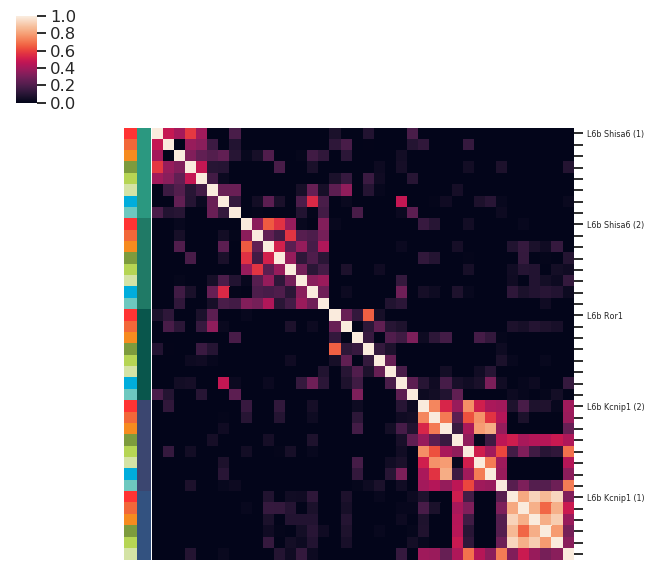

9 merging...
9 formating...
9 sch clustering...
9 plotting...


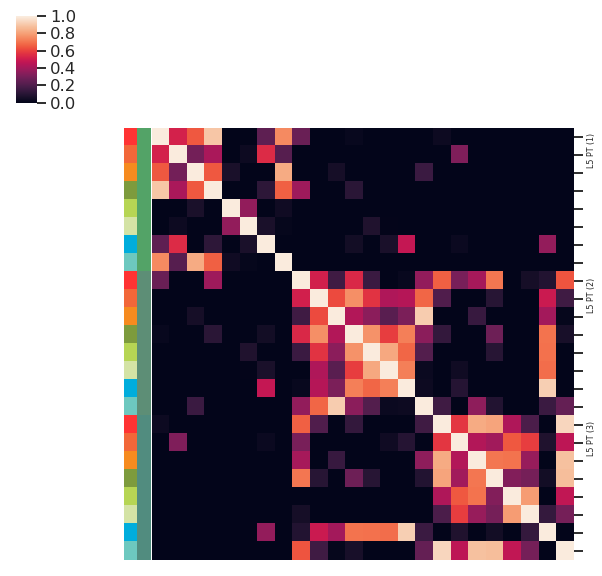

In [43]:
mods_included = [
 'smarter_cells',
 '10x_cells_v3',
 '10x_cells_v2',
 'smarter_nuclei',
 '10x_nuclei_v3_macosko',
 '10x_nuclei_v3',
 'snatac_gene',
 'snmcseq_gene',
]
#     mods_included = mods_selected
mod_reference = features_selected[0]

for cells_file, imputed_data_file, celltype in zip(cells_files, imputed_data_files, celltypes):
    print(celltype, "merging...")

    
    cells_all = np.load(cells_file, allow_pickle=True)
    imputed_data = np.load(imputed_data_file, allow_pickle=True) 

    # cluster centroids of imputed data
    cluster_centroids = collections.OrderedDict()
    for (clst, mod), df_sub in df_info.loc[cells_all].groupby([joint_cluster, 'modality']):
        if mod in mods_included:
            cells_sub = df_sub.index.values
            cells_sub_idx = snmcseq_utils.get_index_from_array(cells_all, cells_sub)
            if mod not in cluster_centroids.keys():
                cluster_centroids[mod] = {}
            cluster_centroids[mod][clst] = np.ravel(imputed_data[cells_sub_idx,:].mean(axis=0))
    
    if set(cluster_centroids.keys()) != set(mods_selected):
        print(celltype, "skipping...")
        continue
        
    print(celltype, "formating...")
    cluster_centroids_df = collections.OrderedDict()
    for mod in mods_selected:
        if mod in mods_included:
            cluster_centroids_df[mod] = pd.DataFrame(cluster_centroids[mod])

    # each modality and cluster
    uniq_clusters = df_info[joint_cluster].unique()
#     corr_grand_clusters = np.hstack([[mod+'_'+str(clst)
#                                     for clst in cluster_centroids_df[mod].columns.values]
#                                     for mod in mods_included])

    # grand correlation matrix
    corr_grand = {}
    for i, mod_x in enumerate(mods_included):
        for j, mod_y in enumerate(mods_included):
            if j >= i:
                gene_x = cluster_centroids_df[mod_x].index.values 
                gene_y = cluster_centroids_df[mod_y].index.values
                gene_common = np.intersect1d(gene_x, gene_y) # redundant 1/3/2020 Fangming
                _x = (cluster_centroids_df[mod_x].loc[gene_common]).rank(axis=0).T.values
                _y = (cluster_centroids_df[mod_y].loc[gene_common]).rank(axis=0).T.values
                corr = np.corrcoef(_x, _y)[:len(_x), len(_x):]
                corr_grand[(i, j)] = corr
                if j != i:
                    corr_grand[(j, i)] = corr.T

    corr_grand = np.hstack([np.vstack([
                        corr_grand[(i, j)] for i in range(len(mods_included))
                        ])
                    for j in range(len(mods_included))
                    ])

    corr_grand_label = np.hstack([[str(joint_annot.loc[clst, 'annot'])
                                   for clst in cluster_centroids_df[mod].columns.values] 
                                for mod in mods_included
                                ])
    corr_grand_clsts = np.hstack([cluster_centroids_df[mod].columns.values
                                for mod in mods_included
                                ])
    corr_grand_mods = np.hstack([
                                [mod]*len(cluster_centroids_df[mod].columns.values) for mod in mods_included
                                ])
    

    # colors
    corr_grand_mod_colors = np.array([settings[mod].color for mod in corr_grand_mods])
    corr_grand_clst_colors = np.array([joint_clst_colors[clst] for clst in corr_grand_clsts])

    print(celltype, "sch clustering...")
    # plot
    mat = corr_grand
    Z = sch.linkage(mat, method='average')
    dn = sch.dendrogram(Z, no_plot=True)

    print(celltype, "plotting...")
#     g = sns.clustermap(mat[dn['leaves'],:][:,dn['leaves']], 
#                        row_cluster=False, col_cluster=False,
#                        row_colors=[corr_grand_mod_colors[dn['leaves']], 
#                                    corr_grand_clst_colors[dn['leaves']], 
#                                   ], 
#                        yticklabels=snmcseq_utils.dedup_array_elements(corr_grand_label[dn['leaves']]),
#                        xticklabels=[],
#                       )

    # reorder
    orders = np.hstack([[mod+"_"+clst
                                   for clst in cluster_centroids_df[mod].columns.values] 
                                for mod in mods_included
                                ])
    new_orders = np.ravel(np.vstack([[mod+"_"+clst if clst in cluster_centroids_df[mod].columns.values else ''
                                   for clst in uniq_clusters] 
                                for mod in mods_included
                                ]).T
                         )
    new_orders = [x for x in new_orders if x]
    idx_reorder = snmcseq_utils.get_index_from_array(orders, new_orders)
    g = sns.clustermap(mat[idx_reorder,:][:,idx_reorder], 
                       row_cluster=False, col_cluster=False,
                       row_colors=[corr_grand_mod_colors[idx_reorder], 
                                   corr_grand_clst_colors[idx_reorder], 
                                  ], 
                       yticklabels=snmcseq_utils.dedup_array_elements(corr_grand_label[idx_reorder]),
                       xticklabels=[],
                       vmax=1,
                       vmin=0,
                      )
    
    g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize=8)
    g.savefig(output_figures.format('round1_8_dataset_heatmap_{}'.format(celltype), 'pdf'), bbox_inches='tight')
    plt.show()

## buffer 

In [54]:
def plot_5_version2(base_cluster, joint_cluster, 
                    order_joint,
           output='',
          ):
    nx = len(mods_ordered)
    ny = 2
    heatmap_kws = {
        'xticklabels': False, 
        'yticklabels': False,
        'vmin': 0, 
        'vmax': 1,
        'cmap': 'Reds',
    }

    cbar_kws = {
        'orientation': 'vertical', 
        'label': 'Fraction of cells',
    }

    with sns.plotting_context('talk'):
        fig, axs = plt.subplots(ny, nx, figsize=(3*nx, 3*ny))
        axs = axs.T
        cbar_ax = fig.add_axes([0.95, 0.4, 0.03, 0.3])
        njoint_clusters = len(df_info[joint_cluster].unique())
        for i, (mod, ax) in enumerate(zip(mods_ordered[::-1], axs)):
            conf_mat = pd.crosstab(df_info.loc[df_info['modality']==mod, base_cluster], 
                                   df_info.loc[df_info['modality']==mod, joint_cluster],
                                  ) #.fillna(0)
            # normalize each joint cluster
            conf_mat_njoint = conf_mat.divide(conf_mat.sum(axis=0), axis=1)
            # normalize each orig cluster
            conf_mat_norig = conf_mat.divide(conf_mat.sum(axis=1), axis=0)

            # plot normalized by joint 
            if i == 0:
                ylabel = 'Row normalized\n{} joint clusters'.format(njoint_clusters)
                cbar = True
            else:
                ylabel = ''
                cbar = False
                
            order_joint = order_joint_sch
            _X = conf_mat_njoint.reindex(order_joint, axis=1, fill_value=0) 
            _rX, ri, rc = snmcseq_utils.diag_matrix_rows(_X.values, _X.index.values, _X.columns.values)
            _rX = pd.DataFrame(_rX, index=ri, columns=rc)
            g = sns.heatmap(_rX.T, 
                        cbar=cbar,
                        cbar_kws=cbar_kws,
                        cbar_ax=cbar_ax,
                        ax=ax[0],
                        **heatmap_kws,
                       )
            g.axes.set_title('{}\n{} clusters'.format(settings[mod].name, _rX.shape[0]))
            g.axes.set_ylabel(ylabel)
            order_orig = _rX.index.values # Will be fixed for the mod clusters  
            # bounding box
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)
                spine.set_color(settings[mod].color)

            # plot normalized by orig (according to the axis of normalized by joint) 
            _X = conf_mat_norig.reindex(order_orig, axis=0).reindex(order_joint, axis=1).fillna(0)
            g = sns.heatmap(_X.T, 
                        cbar=False,
                        ax=ax[1],
                        **heatmap_kws,
                       )
            if i == 0:
                g.axes.set_xlabel('')
                g.axes.set_ylabel('Col normalized\n{} joint clusters'.format(njoint_clusters))
            else:
                g.axes.set_xlabel('')
                g.axes.set_ylabel('')
            # bounding box
            for _, spine in g.axes.spines.items():
                spine.set_visible(True)
                spine.set_color(settings[mod].color)

        plt.subplots_adjust(hspace=0.05, wspace=0.05)
        fig.savefig(output, bbox_inches='tight')
        plt.show()

In [55]:
# get cluster order
_mat = pd.DataFrame(cluster_centroids['10x_cells_v2']).T
Z = sch.linkage(_mat.values, method='average')
order_joint_sch = _mat.index.values[sch.dendrogram(Z, no_plot=True)['leaves']]

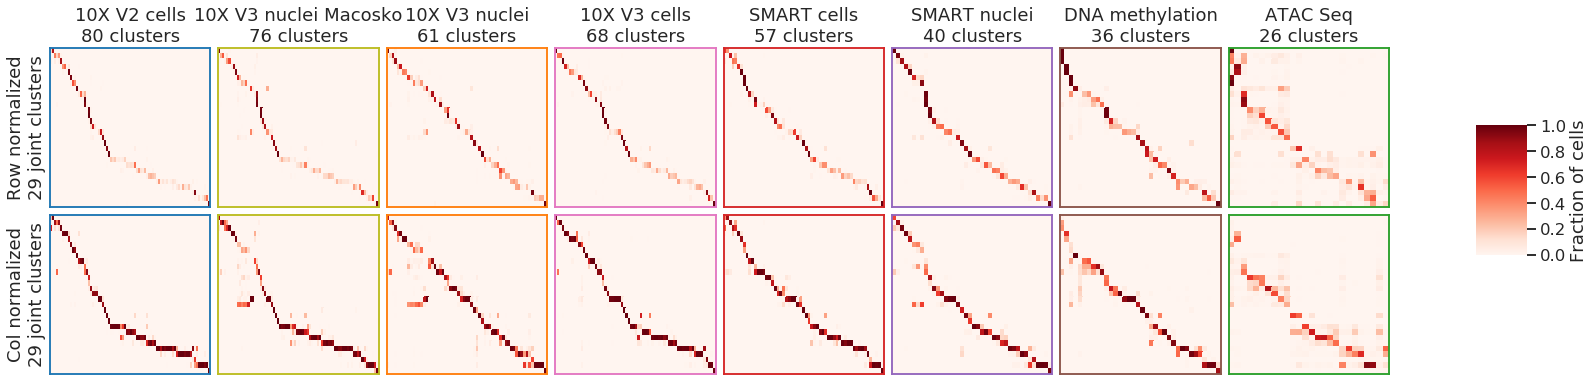

In [24]:
base_cluster = 'cluster'
plot_5_version2(base_cluster, joint_cluster, order_joint_sch, 
       output=output_figures.format('round2_5', 'pdf'),
       )

### tSNE 2 

In [190]:
cells_all = np.load(output_cells_all, allow_pickle=True)
imputed_data = np.load(output_imputed_data_format.format(mod_reference), allow_pickle=True)

# cluster centroids of imputed data
base_cluster = 'cluster'
cluster_centroids_single = collections.OrderedDict()
for (clst, mod), df_sub in df_info.groupby([base_cluster, 'modality']):
    if mod in mods_included:
        cells_sub = df_sub.index.values
        cells_sub_idx = snmcseq_utils.get_index_from_array(cells_all, cells_sub)
        if mod not in cluster_centroids_single.keys():
            cluster_centroids_single[mod] = {}
        cluster_centroids_single[mod][clst] = np.ravel(imputed_data[cells_sub_idx,:].mean(axis=0))
        
cluster_centroids_single['intg'] = {}
for clst, df_sub in df_info.groupby([joint_cluster]):
    cells_sub = df_sub.index.values
    cells_sub_idx = snmcseq_utils.get_index_from_array(cells_all, cells_sub)
    cluster_centroids_single['intg'][clst] = np.ravel(imputed_data[cells_sub_idx,:].mean(axis=0))

In [189]:
base_annot = df_info.groupby(['modality', 'cluster']).first()[['annot']].reset_index()
intg_annot = df_info.groupby(joint_cluster)[[joint_cluster, joint_cluster+'_anno']].first().rename(columns={joint_cluster: 'cluster', 
                                                                                                            joint_cluster+'_anno': 'annot',
                                                                                                           })
intg_annot['modality'] = 'intg'
annots = pd.concat([base_annot, intg_annot], sort=False)
print(annots.shape)
annots.head()

(500, 3)


modality cluster         annot
0  10x_cells_v2       1    Lamp5 Pax6
1  10x_cells_v2      10    Sncg Npy2r
2  10x_cells_v2      11  Sncg Calb1_1
3  10x_cells_v2      12  Sncg Calb1_2
4  10x_cells_v2      13  Vip Crispld2

In [194]:
# cluster_centroids
# cluster_meta
dfs = []
centroids_meta = []
for mod, mod_centroids in cluster_centroids_single.items():
    df = pd.DataFrame(mod_centroids)
    for col in df.columns.values:
        centroids_meta.append({
            'modality': mod,
            'cluster': col,
            })
    df.columns = [mod + '_' + str(col) for col in df.columns.values]
    dfs.append(df)
dfs = pd.concat(dfs, axis=1)

centroids_meta = pd.DataFrame(centroids_meta)
centroids_meta['sample'] = (centroids_meta['modality'] + '_' + centroids_meta['cluster'].astype(str)).values

print(centroids_meta.shape)
centroids_meta.head()

df_umap = CEMBA_run_tsne.run_umap(dfs, n_neighbors=10, n_pc=50, min_dist=0.7)
df_umap = df_umap.join(centroids_meta.set_index('sample'))
df_umap = pd.merge(df_umap.reset_index(), annots, on=['cluster', 'modality']).set_index('sample')

print(df_umap.shape)
df_umap.head()

01/06/2020 10:34:11 AM Running tsne: 50 PC, 10 n_neighbors, 0.7 min_dist , 2 dim.
Input shape: (4067, 500)


(500, 3)


01/06/2020 10:34:12 AM Done with tSNE. running time: 1.0908095836639404 seconds.


(500, 5)


tsne_x    tsne_y cluster      modality         annot
sample                                                                  
10x_cells_v2_1   -8.972017 -5.123970       1  10x_cells_v2    Lamp5 Pax6
10x_cells_v2_10 -13.597535  1.028455      10  10x_cells_v2    Sncg Npy2r
10x_cells_v2_11 -15.298055  1.026054      11  10x_cells_v2  Sncg Calb1_1
10x_cells_v2_12 -14.508906  1.163115      12  10x_cells_v2  Sncg Calb1_2
10x_cells_v2_13 -14.059479 -1.251475      13  10x_cells_v2  Vip Crispld2

In [198]:
# print(centroids_meta.shape, df_umap.shape, dfs.shape)
# print(np.unique(centroids_meta['sample'].values).shape)
# print(cluster_centroids_single['smarter_cells'].keys())
# print(centroids_meta['sample'].value_counts())

In [380]:
# f = '/cndd/fangming/CEMBA/data/MOp_all/results_final/cluster_centroids_umap.tsv'
# df_umap.to_csv(f, sep='\t', na_rep='NA', index=True, header=True)

01/08/2020 08:09:31 PM No handles with labels found to put in legend.


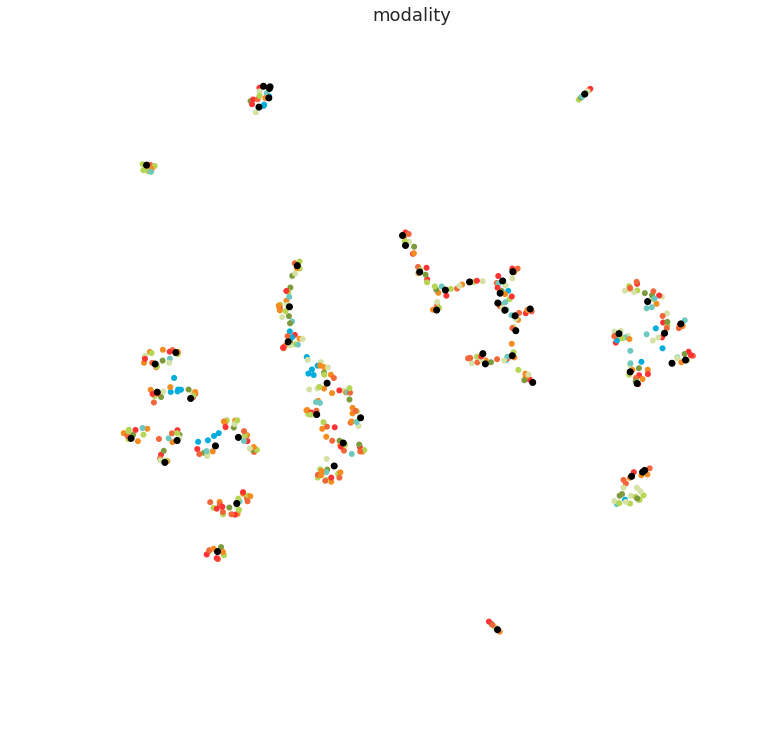

In [383]:
from adjustText import adjust_text
np.random.seed(0)

kw_colors = mod_colors.copy()
kw_colors['intg'] = 'black'

fig, ax = plt.subplots(figsize=(12,12))
tx, ty, tc = 'tsne_x', 'tsne_y', 'modality'
legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
# cond = df_umap['annot'].str.contains(r'^Pv')
snmcseq_utils.plot_tsne_labels_ax(df_umap, ax, tx, ty, tc, 
                                  legend_kws=legend_kws,
                                  kw_colors=kw_colors,
                                  sample_n=sample_n,
                                  legend_mode=-1,
                                  rasterized=True,
                                  s=20,
                                 )

cond = df_umap['modality']=='intg'
snmcseq_utils.plot_tsne_labels_ax(df_umap[cond], ax, tx, ty, tc, 
                                  legend_kws=legend_kws,
                                  kw_colors=kw_colors,
                                  sample_n=sample_n,
                                  legend_mode=-1,
                                  rasterized=True,
                                  s=30,
                                 )
# texts = []
# for idx, row in df_umap[df_umap['modality']=='intg'].iterrows():
#     _x, _y, _label = row[tx], row[ty], row['annot']
#     texts.append(ax.text(_x, _y, _label))
# adjust_text(texts)
# ax.set_aspect('equal')
ax.get_legend().remove()
ax.axis('off')
output = output_figures.format('round2_10', 'pdf')
fig.savefig(output, dpi=300, bbox_inches='tight')
plt.show()

01/06/2020 10:37:14 AM No handles with labels found to put in legend.


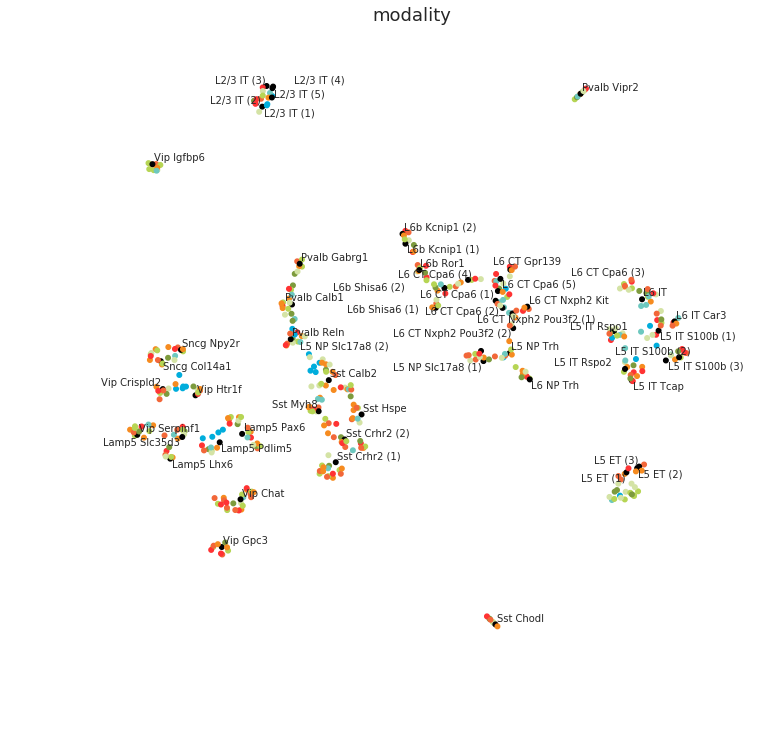

In [200]:
from adjustText import adjust_text
np.random.seed(0)

kw_colors = mod_colors.copy()
kw_colors['intg'] = 'black'

fig, ax = plt.subplots(figsize=(12,12))
tx, ty, tc = 'tsne_x', 'tsne_y', 'modality'
legend_kws = {'bbox_to_anchor': (1, 1), 'loc': 'upper left'}
# cond = df_umap['annot'].str.contains(r'^Pv')
cond = ~df_umap['modality'].isnull()
snmcseq_utils.plot_tsne_labels_ax(df_umap[cond], ax, tx, ty, tc, 
                                  legend_kws=legend_kws,
                                  kw_colors=kw_colors,
                                  sample_n=sample_n,
#                                   legend_size=30,
                                  legend_mode=-1,
                                  rasterized=True,
                                  s=20,
                                 )
texts = []
for idx, row in df_umap[df_umap['modality']=='intg'].iterrows():
    _x, _y, _label = row[tx], row[ty], row['annot']
    texts.append(ax.text(_x, _y, _label))
adjust_text(texts)
# ax.set_aspect('equal')
ax.get_legend().remove()
ax.axis('off')
output = output_figures.format('round2_10_separated', 'pdf')
fig.savefig(output, dpi=300, bbox_inches='tight')
plt.show()

# Gene level features:

In [10]:
df_genes = pd.read_csv(PATH_GENEBODY_ANNOTATION, sep='\t')
df_genes['gene_id_abbr'] = df_genes['gene_id'].apply(lambda x: x.split('.')[0])
df_genes = df_genes.set_index('gene_id_abbr')
print(df_genes.shape)
df_genes.head()

(53379, 7)


gene_id      gene_name   chr    start  \
gene_id_abbr                                                             
ENSMUSG00000102693  ENSMUSG00000102693.1  4933401J01Rik  chr1  3073253   
ENSMUSG00000064842  ENSMUSG00000064842.1        Gm26206  chr1  3102016   
ENSMUSG00000051951  ENSMUSG00000051951.5           Xkr4  chr1  3205901   
ENSMUSG00000102851  ENSMUSG00000102851.1        Gm18956  chr1  3252757   
ENSMUSG00000103377  ENSMUSG00000103377.1        Gm37180  chr1  3365731   

                        end strand             gene_type  
gene_id_abbr                                              
ENSMUSG00000102693  3074322      +                   TEC  
ENSMUSG00000064842  3102125      +                 snRNA  
ENSMUSG00000051951  3671498      -        protein_coding  
ENSMUSG00000102851  3253236      +  processed_pseudogene  
ENSMUSG00000103377  3368549      -                   TEC

In [11]:
df_genes_v2 = df_genes.reset_index().groupby('gene_name').first()
df_genes_v2.head()

gene_id_abbr               gene_id    chr      start  \
gene_name                                                                   
0610005C13Rik  ENSMUSG00000109644  ENSMUSG00000109644.1   chr7   45567794   
0610006L08Rik  ENSMUSG00000108652  ENSMUSG00000108652.1   chr7   74818818   
0610009B22Rik  ENSMUSG00000007777  ENSMUSG00000007777.9  chr11   51685386   
0610009E02Rik  ENSMUSG00000086714  ENSMUSG00000086714.1   chr2   26445696   
0610009L18Rik  ENSMUSG00000043644  ENSMUSG00000043644.4  chr11  120348678   

                     end strand                      gene_type  
gene_name                                                       
0610005C13Rik   45575327      -                  antisense_RNA  
0610006L08Rik   74853813      -                        lincRNA  
0610009B22Rik   51688874      -                 protein_coding  
0610009E02Rik   26459390      +           processed_transcript  
0610009L18Rik  120351190      +  bidirectional_promoter_lncRNA

In [12]:
f_meta_format = '{0}/{1}_metadata.tsv'
f_data_format = '{0}/{1}_{2}raw.{3}'
f_hvftr_format = '{0}/{1}_hvfeatures.{2}'
f_ftr_format = '{0}/{1}_features.{2}'

In [13]:
gxc_ftrs = {}
for mod in mods_selected:
    ti = time.time()
    print(mod)
    
    # read data matrix
    if settings[mod].mod_category == 'mc':
        f_data = f_ftr_format.format(DATA_DIR, mod, 'tsv')
        # read in files
        print(mod, "Reading in files {}".format(time.time()-ti))
        gxc_ftrs[mod] = pd.read_csv(f_data, sep='\t', index_col=0)
        print(time.time()-ti)
        
    else:
        f_data = f_ftr_format.format(DATA_DIR, mod, 'npz') 
        f_data_gene = f_ftr_format.format(DATA_DIR, mod, 'gene') 
        f_data_cell = f_ftr_format.format(DATA_DIR, mod, 'cell') 
        
        # read in files
        print(mod, "Reading in files {}".format(time.time()-ti))
        gxc_ftrs[mod] = snmcseq_utils.load_gc_matrix(f_data_gene, f_data_cell, f_data) # checked dimensions in agreement internally
        print(gxc_ftrs[mod].data.shape)
        print(time.time()-ti)
    
    print(mod, "Total time used: {}".format(time.time()-ti))
    

snmcseq_gene
snmcseq_gene Reading in files 8.702278137207031e-05
132.93485856056213
snmcseq_gene Total time used: 132.93501091003418
snatac_gene
snatac_gene Reading in files 4.267692565917969e-05
(53278, 54844)
46.09390616416931
snatac_gene Total time used: 46.09392690658569
smarter_cells
smarter_cells Reading in files 2.5272369384765625e-05
(32324, 6244)
10.94198727607727
smarter_cells Total time used: 10.942009925842285
smarter_nuclei
smarter_nuclei Reading in files 3.0517578125e-05
(32324, 5911)
7.944780349731445
smarter_nuclei Total time used: 7.944799900054932
10x_cells_v2
10x_cells_v2 Reading in files 2.47955322265625e-05
(31053, 121440)
106.64085984230042
10x_cells_v2 Total time used: 106.64089179039001
10x_cells_v3
10x_cells_v3 Reading in files 4.887580871582031e-05
(31053, 69727)
101.84206795692444
10x_cells_v3 Total time used: 101.84209275245667
10x_nuclei_v3
10x_nuclei_v3 Reading in files 3.743171691894531e-05
(31053, 39706)
28.106483459472656
10x_nuclei_v3 Total time used: 

-0.374324877987 2.33763230145
-0.361456708552 2.5566636551
-0.312769375237 2.56982199021
-0.430309229262 2.89599456362
-0.251830789416 1.01976074725
-0.260892571339 2.02154444046
-1.84659361771 -1.21651813032
-0.511760796497 2.24424591829


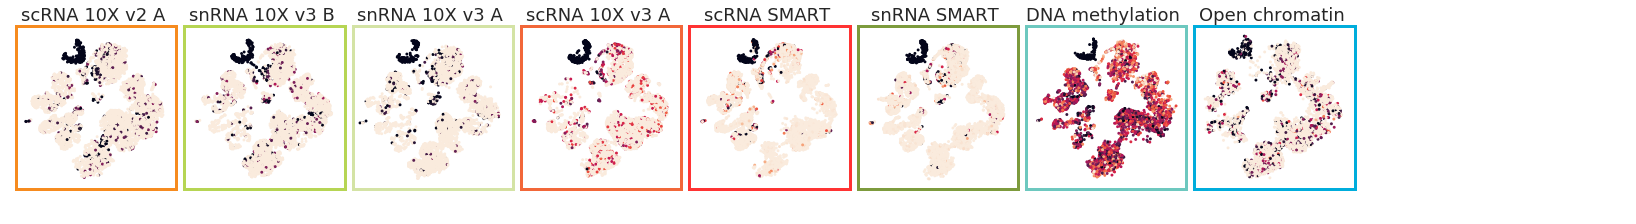

In [155]:
genes_inq = [
    'Tshz2',
#     'Bcl6', 
#     'Slco2a1', 
#     'Hpgd', 
#     'Npsr1', 
#     'Tshz2',
]
    
sample_n = 5000

with sns.axes_style('white'):
    n = len(mods_ordered)
    nx = 9
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(3*nx,3*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]
    
    cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])
    
    for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
        if settings[mod].mod_category == 'mc':
            genes = gxc_ftrs[mod].index.values
            gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
            gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
            gene_data = gxc_ftrs[mod].iloc[gene_idx].T.rename(columns={gene_ids_inq[0]: genes_inq[0]})
        else:
            genes = gxc_ftrs[mod].gene
            cells = gxc_ftrs[mod].cell
            gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
            gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
            gene_data = np.ravel(gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense())
            gene_data = pd.Series(gene_data, index=cells).to_frame(genes_inq[0])
        
        # normalize gene_data
        if settings[mod].mod_category == 'mc':
            gene_data = settings[mod].mod_direction*gene_data #*(gene_data - gene_data.mean())
        else:
            gene_data = settings[mod].mod_direction*(gene_data - gene_data.mean())/gene_data.std()
            

        df_mod = df_info[df_info['modality']==mod]
        if sample_n > len(df_mod):
            df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
        else:
            df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
                         .sample(sample_n, replace=False)
                      )
    
        if i == 0: 
            cbar = False
        else:
            cbar = False
#         vmin, vmax = -1, 1
        
        vmin, vmax = np.percentile(df_plot[tc], 5), np.percentile(df_plot[tc], 95)
        print(vmin, vmax)
        snmcseq_utils.plot_tsne_values_ax(df_plot, ax, tx, ty, tc, 
                                          s=2,
                                          cbar=cbar,
                                          vmax=vmax,
                                          vmin=vmin,
                                          cbar_ax=cbar_ax,
                                          cmap='rocket_r',
                                          rasterized=True,
                                         )
        ax.set_title('{} '.format(settings[mod].name, ))
#         ax.set_title('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('auto')
        
        for _, spine in ax.spines.items():
            spine.set_color(settings[mod].color)
            spine.set_linewidth(3)
        
    for ax in axs[n:]:
        ax.axis('off')
    cbar_ax.axis('off')
    
        
        
    
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format('6_{}'.format(genes_inq[0]), 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()
    

In [ ]:
genes_inq = [
    'Tshz2',
#     'Bcl6', 
#     'Slco2a1', 
#     'Hpgd', 
#     'Npsr1', 
#     'Tshz2',
]
    
sample_n = 5000
gene_data_allmod = {}
with sns.axes_style('white'):
    n = len(mods_ordered)
    nx = 9
    ny = int((n+nx-1)/nx)
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]
    
    for i, mod in enumerate(mods_ordered[::-1]):
        if settings[mod].mod_category == 'mc':
            genes = gxc_ftrs[mod].index.values
            gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
            gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
            gene_data = gxc_ftrs[mod].iloc[gene_idx].T.rename(columns={gene_ids_inq[0]: genes_inq[0]})
        else:
            genes = gxc_ftrs[mod].gene
            cells = gxc_ftrs[mod].cell
            gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 
            gene_idx = snmcseq_utils.get_index_from_array(genes, gene_ids_inq)
            gene_data = np.ravel(gxc_ftrs[mod].data.tocsr()[gene_idx, :].todense())
            gene_data = pd.Series(gene_data, index=cells).to_frame(genes_inq[0])
        
        gene_data_allmod[mod] = gene_data


In [167]:
    
n = len(mods_ordered)
nx = 9
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny, nx, figsize=(3*nx,3*ny))
axs = axs.flatten()
tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]
for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
    continue
# for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
    print(i)
#     sns.distplot(gene_data_allmod[mod], ax=ax)
#     ax.set_title(mod)

IndentationError: expected an indented block (<ipython-input-167-1bc7a58e864a>, line 10)

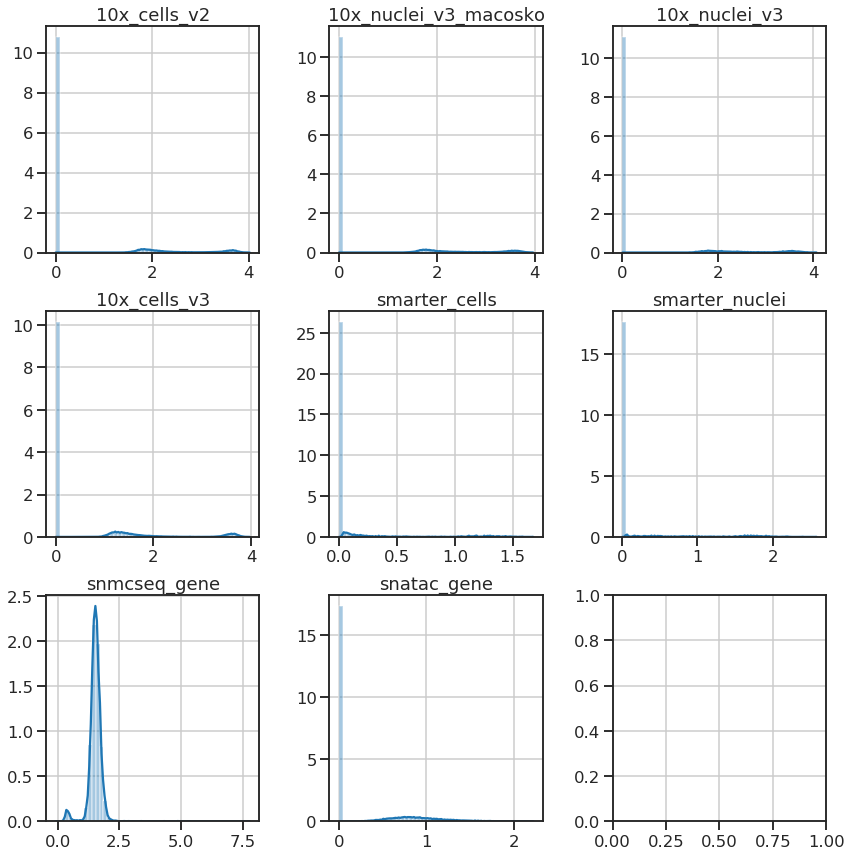

In [185]:
n = len(mods_ordered)
nx = 3
ny = int((n+nx-1)/nx)

fig, axs = plt.subplots(ny, nx, figsize=(4*nx,4*ny))
axs = axs.flatten()
tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]

for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
    sns.distplot(gene_data_allmod[mod], ax=ax)
    ax.set_title(mod)
#     ax.set_yscale('log')
    
fig.tight_layout()

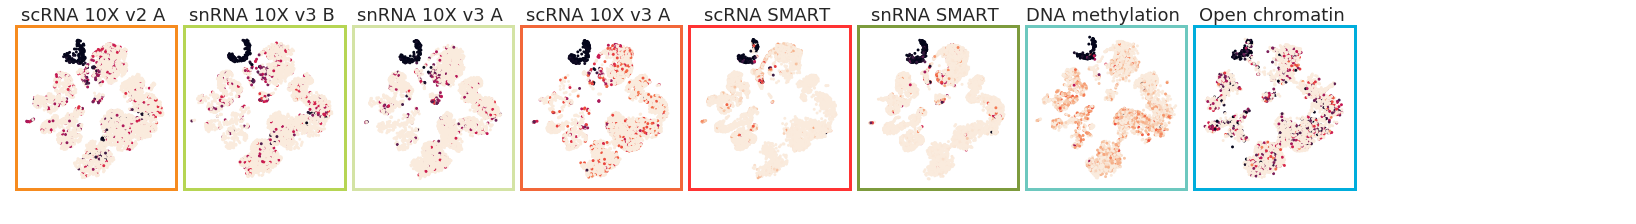

In [202]:
genes_inq = [
    'Tshz2',
#     'Bcl6', 
#     'Slco2a1', 
#     'Hpgd', 
#     'Npsr1', 
#     'Tshz2',
]
    
sample_n = 5000

with sns.axes_style('white'):
    n = len(mods_ordered)
    nx = 9
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(3*nx,3*ny))
    axs = axs.flatten()
    tx, ty, tc = 'tsne_x_joint', 'tsne_y_joint', genes_inq[0]
    
    cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])
    
    for i, (ax, mod) in enumerate(zip(axs, mods_ordered[::-1])):
        gene_data = gene_data_allmod[mod]
        
        # normalize gene_data
#         gene_data = settings[mod].mod_direction*gene_data #*(gene_data - gene_data.mean())
        if settings[mod].mod_category != 'mc':
            vmax = np.percentile(gene_data[tc], 98)
            gene_data = gene_data/vmax
        else:
            vmin, vmax = np.percentile(gene_data[tc], 2), np.percentile(gene_data[tc], 50)
            gene_data = 1 - (gene_data-vmin)/(vmax-vmin)
            
        df_mod = df_info[df_info['modality']==mod]
        if sample_n > len(df_mod):
            df_plot = pd.merge(gene_data, df_mod, left_index=True, right_index=True)
        else:
            df_plot = (pd.merge(gene_data, df_mod, left_index=True, right_index=True)
                         .sample(sample_n, replace=False)
                      )
    
        if i == 0: 
            cbar = False
        else:
            cbar = False
        
#         if settings[mod].mod_category == 'mc':
#             vmin, vmax = -1, 0
#         else:
#             vmin, vmax = 0, 1
        vmin, vmax = 0, 1
        
        snmcseq_utils.plot_tsne_values_ax(df_plot, ax, tx, ty, tc, 
                                          s=2,
                                          cbar=cbar,
                                          low_p=0, hi_p=100,
                                          vmax=vmax,
                                          vmin=vmin,
                                          cbar_ax=cbar_ax,
                                          cmap='rocket_r',
                                          rasterized=True,
                                         )
        ax.set_title('{} '.format(settings[mod].name, ))
#         ax.set_title('')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_aspect('auto')
        
        for _, spine in ax.spines.items():
            spine.set_color(settings[mod].color)
            spine.set_linewidth(3)
        
    for ax in axs[n:]:
        ax.axis('off')
    cbar_ax.axis('off')
    
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format('6_{}'.format(genes_inq[0]), 'pdf'), bbox_inches='tight', dpi=300)
    plt.show()
    

In [64]:
# # cluster centroids (for each dataset)

# joint_cluster = 'joint_cluster_round2'
# f_out_format = '/cndd2/fangming/miniatlas/cluster_level/cell_mean/gene_features_{}_round2.tsv'

# for mod in mods_selected:
#     print(mod)
#     if settings[mod].mod_category == 'mc':
#         X = gxc_ftrs[mod].T # cell by gene 
#     else:
#         X = pd.DataFrame(gxc_ftrs[mod].data.todense(), 
#                          index=gxc_ftrs[mod].gene, 
#                          columns=gxc_ftrs[mod].cell).T # cell by gene
    
#     # get cluster mean
#     centroids_x = {}
#     for clst, df_sub in df_info.groupby(joint_cluster):
#         print(clst, end='')
#         cells_sub = df_sub.index.values
#         cells_sub_x = np.intersect1d(cells_sub, X.index.values)
#         centroids_x[clst] = X.loc[cells_sub_x].mean()
#     centroids_x = pd.DataFrame(centroids_x).dropna(axis=1)
#     print(centroids_x.shape)
#     f = f_out_format.format(mod)
#     centroids_x.to_csv(f, sep='\t', na_rep='NA', header=True, index=True)

snmcseq_gene
1-11-210-12-12-22-33-13-23-34-14-25-15-25-35-45-56-16-26-36-46-56-67-17-28-18-28-39-19-2(20283, 29)
snatac_gene
1-11-210-12-12-22-33-13-23-34-14-25-15-25-35-45-56-16-26-36-46-56-67-17-28-18-28-39-19-2(53278, 28)
smarter_cells
1-11-210-12-12-22-33-13-23-34-14-25-15-25-35-45-56-16-26-36-46-56-67-17-28-18-28-39-19-2(32324, 29)
smarter_nuclei
1-11-210-12-12-22-33-13-23-34-14-25-15-25-35-45-56-16-26-36-46-56-67-17-28-18-28-39-19-2(32324, 28)
10x_cells_v2
1-11-210-12-12-22-33-13-23-34-14-25-15-25-35-45-56-16-26-36-46-56-67-17-28-18-28-39-19-2(31053, 29)
10x_cells_v3
1-11-210-12-12-22-33-13-23-34-14-25-15-25-35-45-56-16-26-36-46-56-67-17-28-18-28-39-19-2(31053, 29)
10x_nuclei_v3
1-11-210-12-12-22-33-13-23-34-14-25-15-25-35-45-56-16-26-36-46-56-67-17-28-18-28-39-19-2(31053, 29)
10x_nuclei_v3_macosko
1-11-210-12-12-22-33-13-23-34-14-25-15-25-35-45-56-16-26-36-46-56-67-17-28-18-28-39-19-2(24809, 29)


In [65]:
# f_data = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/snmcseq_gene_features_mcg.tsv'
# gxc_ftrs['mcg'] = pd.read_csv(f_data, sep='\t', index_col=0) 

In [66]:
# mod = 'mcg'
# X = gxc_ftrs[mod].T # cell by gene 

# # get cluster mean
# centroids_x = {}
# for clst, df_sub in df_info.groupby(joint_cluster):
#     print(clst, end='')
#     cells_sub = df_sub.index.values
#     cells_sub_x = np.intersect1d(cells_sub, X.index.values)
#     centroids_x[clst] = X.loc[cells_sub_x].mean()
# centroids_x = pd.DataFrame(centroids_x).dropna(axis=1)
# print(centroids_x.shape)
# f = f_out_format.format(mod)
# centroids_x.to_csv(f, sep='\t', na_rep='NA', header=True, index=True)

1-11-210-12-12-22-33-13-23-34-14-25-15-25-35-45-56-16-26-36-46-56-67-17-28-18-28-39-19-2(10318, 29)


In [67]:
# # cluster centroids (for each dataset)

# joint_cluster = 'joint_cluster_round3'
# f_out_format = '/cndd2/fangming/miniatlas/cluster_level/cell_mean/gene_features_{}_round3.tsv'

# for mod in mods_selected:
#     print(mod)
#     if settings[mod].mod_category == 'mc':
#         X = gxc_ftrs[mod].T # cell by gene 
#     else:
#         X = pd.DataFrame(gxc_ftrs[mod].data.todense(), 
#                          index=gxc_ftrs[mod].gene, 
#                          columns=gxc_ftrs[mod].cell).T # cell by gene
    
#     # get cluster mean
#     centroids_x = {}
#     for clst, df_sub in df_info.groupby(joint_cluster):
#         print(clst, end='')
#         cells_sub = df_sub.index.values
#         cells_sub_x = np.intersect1d(cells_sub, X.index.values)
#         centroids_x[clst] = X.loc[cells_sub_x].mean()
#     centroids_x = pd.DataFrame(centroids_x).dropna(axis=1)
#     print(centroids_x.shape)
#     f = f_out_format.format(mod)
#     centroids_x.to_csv(f, sep='\t', na_rep='NA', header=True, index=True)

snmcseq_gene
1-1-11-2-11-2-210-1-12-1-12-1-22-2-12-2-22-2-32-2-42-3-12-3-22-3-33-1-13-1-23-2-13-2-23-3-14-1-14-1-24-2-14-2-24-2-35-1-15-1-25-2-15-2-25-2-35-3-15-3-25-4-15-5-16-1-16-1-26-2-16-3-16-3-26-3-36-4-16-4-26-5-16-5-26-5-36-6-17-1-17-1-27-2-17-2-28-1-18-1-28-2-18-3-18-3-29-1-19-2-19-2-2(20283, 53)
snatac_gene
1-1-11-2-11-2-210-1-12-1-12-1-22-2-12-2-22-2-32-2-42-3-12-3-22-3-33-1-13-1-23-2-13-2-23-3-14-1-14-1-24-2-14-2-24-2-35-1-15-1-25-2-15-2-25-2-35-3-15-3-25-4-15-5-16-1-16-1-26-2-16-3-16-3-26-3-36-4-16-4-26-5-16-5-26-5-36-6-17-1-17-1-27-2-17-2-28-1-18-1-28-2-18-3-18-3-29-1-19-2-19-2-2(53278, 53)
smarter_cells
1-1-11-2-11-2-210-1-12-1-12-1-22-2-12-2-22-2-32-2-42-3-12-3-22-3-33-1-13-1-23-2-13-2-23-3-14-1-14-1-24-2-14-2-24-2-35-1-15-1-25-2-15-2-25-2-35-3-15-3-25-4-15-5-16-1-16-1-26-2-16-3-16-3-26-3-36-4-16-4-26-5-16-5-26-5-36-6-17-1-17-1-27-2-17-2-28-1-18-1-28-2-18-3-18-3-29-1-19-2-19-2-2(32324, 54)
smarter_nuclei
1-1-11-2-11-2-210-1-12-1-12-1-22-2-12-2-22-2-32-2-42-3-12-3-22-3-33

In [68]:
# f_data = '/cndd/fangming/CEMBA/data/MOp_all/data_freeze_neurons/snmcseq_gene_features_mcg.tsv'
# gxc_ftrs['mcg'] = pd.read_csv(f_data, sep='\t', index_col=0) 

In [69]:
# mod = 'mcg'
# X = gxc_ftrs[mod].T # cell by gene 

# # get cluster mean
# centroids_x = {}
# for clst, df_sub in df_info.groupby(joint_cluster):
#     print(clst, end='')
#     cells_sub = df_sub.index.values
#     cells_sub_x = np.intersect1d(cells_sub, X.index.values)
#     centroids_x[clst] = X.loc[cells_sub_x].mean()
# centroids_x = pd.DataFrame(centroids_x).dropna(axis=1)
# print(centroids_x.shape)
# f = f_out_format.format(mod)
# centroids_x.to_csv(f, sep='\t', na_rep='NA', header=True, index=True)

1-1-11-2-11-2-210-1-12-1-12-1-22-2-12-2-22-2-32-2-42-3-12-3-22-3-33-1-13-1-23-2-13-2-23-3-14-1-14-1-24-2-14-2-24-2-35-1-15-1-25-2-15-2-25-2-35-3-15-3-25-4-15-5-16-1-16-1-26-2-16-3-16-3-26-3-36-4-16-4-26-5-16-5-26-5-36-6-17-1-17-1-27-2-17-2-28-1-18-1-28-2-18-3-18-3-29-1-19-2-19-2-2(10318, 53)


### Gene heatmap new

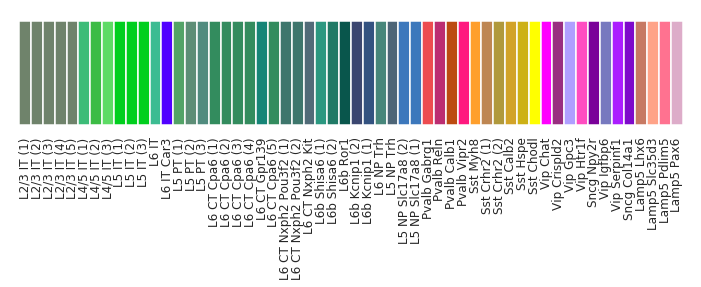

In [44]:
clsts_manual_order = collections.OrderedDict({
      '4-1-1': 'L2/3 IT ',
      '4-1-2': 'L2/3 IT ',
      '4-2-1': 'L2/3 IT ',
      '4-2-2': 'L2/3 IT ',
      '4-2-3': 'L2/3 IT ',
      '1-1-1': 'L5 IT Rspo1_1',
      '1-2-1': 'L5 IT Rspo2_1',
      '1-2-2': 'L5 IT Tcap_1',
      '3-1-2': 'L5 IT S100b',
      '3-2-1': 'L5 IT S100b',
      '3-2-2': 'L5 IT S100b',
      '3-1-1': 'L6 IT_2',
      '3-3-1': 'L6 IT Car3',
    
      '9-1-1': 'L5 ET_1',
      '9-2-1': 'L5 ET_2',
      '9-2-2': 'L5 ET_3',
    
      '2-1-1': 'L6 CT Cpa6',
      '2-1-2': 'L6 CT Cpa6',
      '2-2-1': 'L6 CT Cpa6',
      '2-2-2': 'L6 CT Cpa6',
      '2-2-3': 'L6 CT Gpr139',
      '2-2-4': 'L6 CT Cpa6',
      '2-3-1': 'L6 CT Nxph2 Pou3f2',
      '2-3-2': 'L6 CT Nxph2 Pou3f2',
      '2-3-3': 'L6 CT Nxph2 Kit',
    
      '8-1-1': 'L6b Shisa6_1',
      '8-1-2': 'L6b Shisa6_2_2',
      '8-2-1': 'L6b Ror1',
      '8-3-1': 'L6b Kcnip1_2',
      '8-3-2': 'L6b Kcnip1_2',
    
      '7-1-1': 'L6 NP Trh_1',
      '7-1-2': 'L5 NP Trh',
      '7-2-1': 'L5 NP Slc17a8',
      '7-2-2': 'L5 NP Slc17a8',
    
      '5-4-1': 'Pvalb Gabrg1',
      '5-1-1': 'Pvalb Reln',
      '5-1-2': 'Pvalb Calb1_1',
      '5-5-1': 'Pvalb Vipr2',
    
      '5-2-1': 'Sst Myh8_2',
      '5-2-2': 'Sst Crhr2_1',
      '5-2-3': 'Sst Crhr2_2',
      '5-3-1': 'Sst Calb2',
      '5-3-2': 'Sst Hspe_3',
      '10-1-1': 'Sst Chodl',
    
      '6-1-1': 'Vip Chat',
      '6-1-2': 'Vip Crispld2',
      '6-3-1': 'Vip Gpc3',
      '6-3-2': 'Vip Htr1f_1',
      '6-5-3': 'Sncg Npy2r',
      '6-3-3': 'Vip Igfbp6',
      '6-5-2': 'Vip Serpinf1_2',
      '6-5-1': 'Sncg Col14a1',
    
      '6-6-1': 'Lamp5 Lhx6',
      '6-2-1': 'Lamp5 Slc35d3',
      '6-4-1': 'Lamp5 Pdlim5',
      '6-4-2': 'Lamp5 Pax6',
    
})

with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(12, 2))
    clsts_uniq = np.array(list(clsts_manual_order.keys()))
    to_plot = pd.DataFrame()
    to_plot['color'] = joint_annot.loc[clsts_uniq, 'cluster_color']
    to_plot['bar'] = 1
    to_plot['text'] = joint_annot.loc[clsts_uniq, 'annot']
    (to_plot['bar'].plot.bar(stacked=True, width=1, 
                             alpha=1, 
                             ax=ax,
    #                          legend=False, 
                             color=to_plot['color'].values, 
                             )
    )
    sns.despine(ax=ax, left=True, bottom=True)
    ax.set_xticklabels(to_plot['text'].values, fontsize=12)
    ax.set_yticks([])
    ax.set_xlabel('')
    
    output = output_figures.format('round3_sidebar', 'pdf')
    fig.savefig(output, dpi=300, bbox_inches='tight')
    plt.show()

In [50]:
dir(ax.yaxis)

['OFFSETTEXTPAD',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_agg_filter',
 '_alpha',
 '_animated',
 '_autolabelpos',
 '_axes',
 '_clipon',
 '_clippath',
 '_contains',
 '_copy_tick_props',
 '_get_label',
 '_get_offset_text',
 '_get_pixel_distance_along_axis',
 '_get_tick',
 '_get_tick_bboxes',
 '_get_tick_boxes_siblings',
 '_gid',
 '_gridOnMajor',
 '_gridOnMinor',
 '_label',
 '_major_tick_kw',
 '_minor_tick_kw',
 '_mouseover',
 '_oid',
 '_path_effects',
 '_picker',
 '_prop_order',
 '_propobservers',
 '_rasterized',
 '_remove_method',
 '_scale',
 '_set_artist_props',
 '_set_gc_clip',
 '_set_scale',
 '_sketch',
 '_smart_bounds',
 '_sna

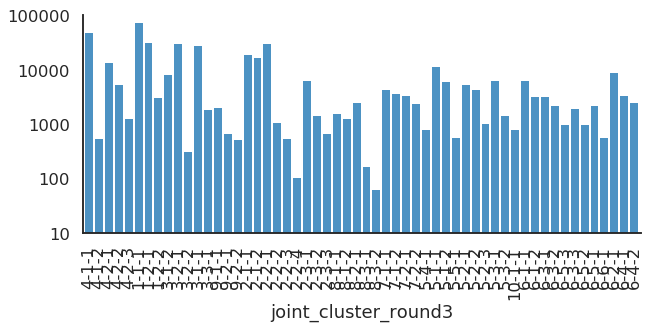

In [55]:
with sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    # 
    fig, ax = plt.subplots(figsize=(10,4))
    hist.sum(axis=1).reindex(clsts_uniq).plot.bar(
        width=0.8,
        rasterized=True,
        alpha=0.8,
        ax=ax)
    sns.despine(ax=ax)
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ScalarFormat)
    ax.set_ylim([10, 10**5])
    snmcseq_utils.savefig(fig, output_figures.format('barplot_cluster_num_cell', 'pdf'))
    plt.show()

In [31]:
output_figures.format('barplot_cluster_num_cell', 'pdf')

'/cndd/fangming/CEMBA/data/MOp_all/results/figures/mop_8mods_0915_k30_barplot_cluster_num_cell_2020-01-29.pdf'

In [16]:
# 
genes_canonical = [
    # neuron
    'Snap25',
    # Exc
    'Satb2',
    # Inh 
    'Gad2',
    
    # Projecting (IT ET CT L6b)
    'Pde1a', # Pan-projection 
    # NP
    'Tshz2', 
    # MGE
    'Sox6',
    'Lhx6',
    # CGE
    'Adarb2',
    
    # IT
    'Slc30a3',
    # IT sub
    # L2-4 
    'Cux2',
    # L4-5
    'Rorb',
    # L5 
    'Deptor',
    # L6
    'Oprk1',
    
    # L5 ET
    'Bcl6',
    
    # L6 CT
    'Foxp2',
    # L6b
    'Nxph4',
    
    # NP again
    'Trhr',
    'Rapgef3',
    'Slc17a8',
    
    # Pv
    'Pvalb',
    'Th',
    'Tac1',
    'Mme',
    'Unc5b',
    # Sst
    'Calb1',
    'Crhr2',
    'Hpse',
    'Chodl',
    
    # Vip Serpinf1
    'Calb2',
    'Vip',
    'Chat',
    'Col15a1',
    'Serpinf1',
    
    # Lamp5 Sncg
    'Lamp5',
    'Sv2c',
    'Plch2',
    'Ntn1',
    
    'Ndnf',
#     'Pax6',
#     'Nr2f2',
    'Reln',
    ]


In [109]:
f_format = '/cndd2/fangming/miniatlas/cluster_level/cell_mean/gene_features_{}_round3.tsv'
centroid_dfs = {}
for mod in mods_selected:
    print(mod)
    if settings[mod].mod_category == 'mc':
        for mod_update in ['mcg', 'mch']:
            f = f_format.format(mod_update)
            centroid_dfs[mod_update] = pd.read_csv(f, sep='\t', index_col=0)
    else:
        f = f_format.format(mod)
        centroid_dfs[mod] = pd.read_csv(f, sep='\t', index_col=0)
    
print(centroid_dfs.keys())
    

snmcseq_gene
snatac_gene
smarter_cells
smarter_nuclei
10x_cells_v2
10x_cells_v3
10x_nuclei_v3
10x_nuclei_v3_macosko
dict_keys(['mcg', 'mch', 'snatac_gene', 'smarter_cells', 'smarter_nuclei', '10x_cells_v2', '10x_cells_v3', '10x_nuclei_v3', '10x_nuclei_v3_macosko'])


In [110]:
mods_updated = [
    'smarter_cells',
    '10x_cells_v3',
    '10x_cells_v2', 
    'smarter_nuclei',
    '10x_nuclei_v3_macosko',
    '10x_nuclei_v3',
    'snatac_gene',
    'mch',
    'mcg',
]

In [111]:
for key, item in centroid_dfs.items():
    print(key, item.shape)

mcg (10318, 53)
mch (20283, 53)
snatac_gene (53278, 53)
smarter_cells (32324, 54)
smarter_nuclei (32324, 51)
10x_cells_v2 (31053, 56)
10x_cells_v3 (31053, 55)
10x_nuclei_v3 (31053, 56)
10x_nuclei_v3_macosko (24809, 55)


In [112]:
mod_update = 'mcg'

gene_data = centroid_dfs[mod_update].reindex(gene_ids_inq)
gene_data.index = genes_inq
gene_data = gene_data
df_plot = gene_data
# normalize gene_data for each row except for mC (already normalized)
df_plot = settings['snmcseq_gene'].mod_direction*df_plot
df_plots[mod_update] = df_plot.reindex(
                                index=genes_inq, 
                                columns=clsts_uniq,
                                )
print(df_plot.shape)
df_plot.head()

(39, 53)


1-1-1     1-2-1     1-2-2    10-1-1     2-1-1     2-1-2     2-2-1  \
Snap25 -0.530974 -0.461745 -0.648766 -1.066399 -0.534029 -0.550880 -0.495476   
Satb2  -0.389644 -0.410051 -0.470013 -0.904892 -0.737942 -0.748923 -0.734331   
Gad2   -0.816486 -0.841902 -0.826002 -0.553514 -0.844195 -0.825732 -0.829614   
Pde1a  -1.047052 -1.013815 -1.066788 -0.767980 -0.999074 -0.992180 -1.005408   
Tshz2  -1.082369 -1.090380 -1.099254 -1.069633 -1.105327 -1.096591 -1.106070   

           2-2-2     2-3-1     2-3-2  ...     7-1-2     7-2-1     7-2-2  \
Snap25 -0.518003 -0.459247 -0.482179  ... -0.726366 -0.717033 -0.676896   
Satb2  -0.560009 -0.529583 -0.494769  ... -0.551335 -0.505445 -0.524147   
Gad2   -0.823677 -0.857450 -0.838260  ... -0.838479 -0.824024 -0.817828   
Pde1a  -0.866547 -0.914452 -0.941763  ... -1.107931 -1.108873 -1.110794   
Tshz2  -1.106753 -1.108523 -1.092724  ... -0.810149 -0.847601 -0.819351   

           8-1-1     8-1-2     8-2-1     8-3-1     9-1-1     9-2-1     9-2-2  
Snap25 -0.611780 -0.528409 -0.779525 -0.518981 -0.280218 -0.492229 -0.344472  
Satb2  -0.537973 -0.552207 -0.484482 -0.502114 -0.737394 -0.388947 -0.424469  
Gad2   -0.887733 -0.894141 -0.839623 -0.865450 -0.810289 -0.858442 -0.845756  
Pde1a  -0.848869 -0.888885 -1.018668 -0.922756 -0.868312 -0.940938 -0.922093  
Tshz2  -1.094170 -1.096977 -1.089870 -1.127773 -1.096719 -1.101409 -1.107278  

[5 rows x 53 columns]

In [152]:
# clsts_uniq = np.sort(np.unique(df_info[joint_cluster]))

# genes_inq = [
#     'Lhx9',
# #     'Fhl5',
#     'Pax6',
# ]
genes_inq = genes_canonical

gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 

df_plots = {} 
for i, mod in enumerate(mods_ordered):
    if settings[mod].mod_category == 'mc':
        for mod_update in ['mcg', 'mch']:
            gene_data = centroid_dfs[mod_update].reindex(gene_ids_inq)

            gene_data.index = genes_inq
#             gene_data = gene_data.dropna(axis=1).dropna(axis=0)
            gene_data = gene_data.dropna(axis=0)
            df_plot = gene_data
            # normalize gene_data for each row except for mC (already normalized)
            df_plot = settings[mod].mod_direction*df_plot
            df_plots[mod_update] = df_plot.reindex(
                                            index=genes_inq, 
                                            columns=clsts_uniq,
                                            )
    else:
        gene_data = centroid_dfs[mod].reindex(gene_ids_inq)
        
        gene_data.index = genes_inq
#         gene_data = gene_data.dropna(axis=1).dropna(axis=0)
        gene_data = gene_data.dropna(axis=0)
        df_plot = gene_data
        # normalize gene_data for each row except for mC (already normalized)
        df_plot = settings[mod].mod_direction*df_plot
#         df_plot = df_plot.divide(df_plot.max(axis=1), axis=0)
#         df_plot = df_plot.divide(df_plot.max(axis=0), axis=1)
        df_plots[mod] = df_plot.reindex(
                                        index=genes_inq, 
                                        columns=clsts_uniq,
                                        )

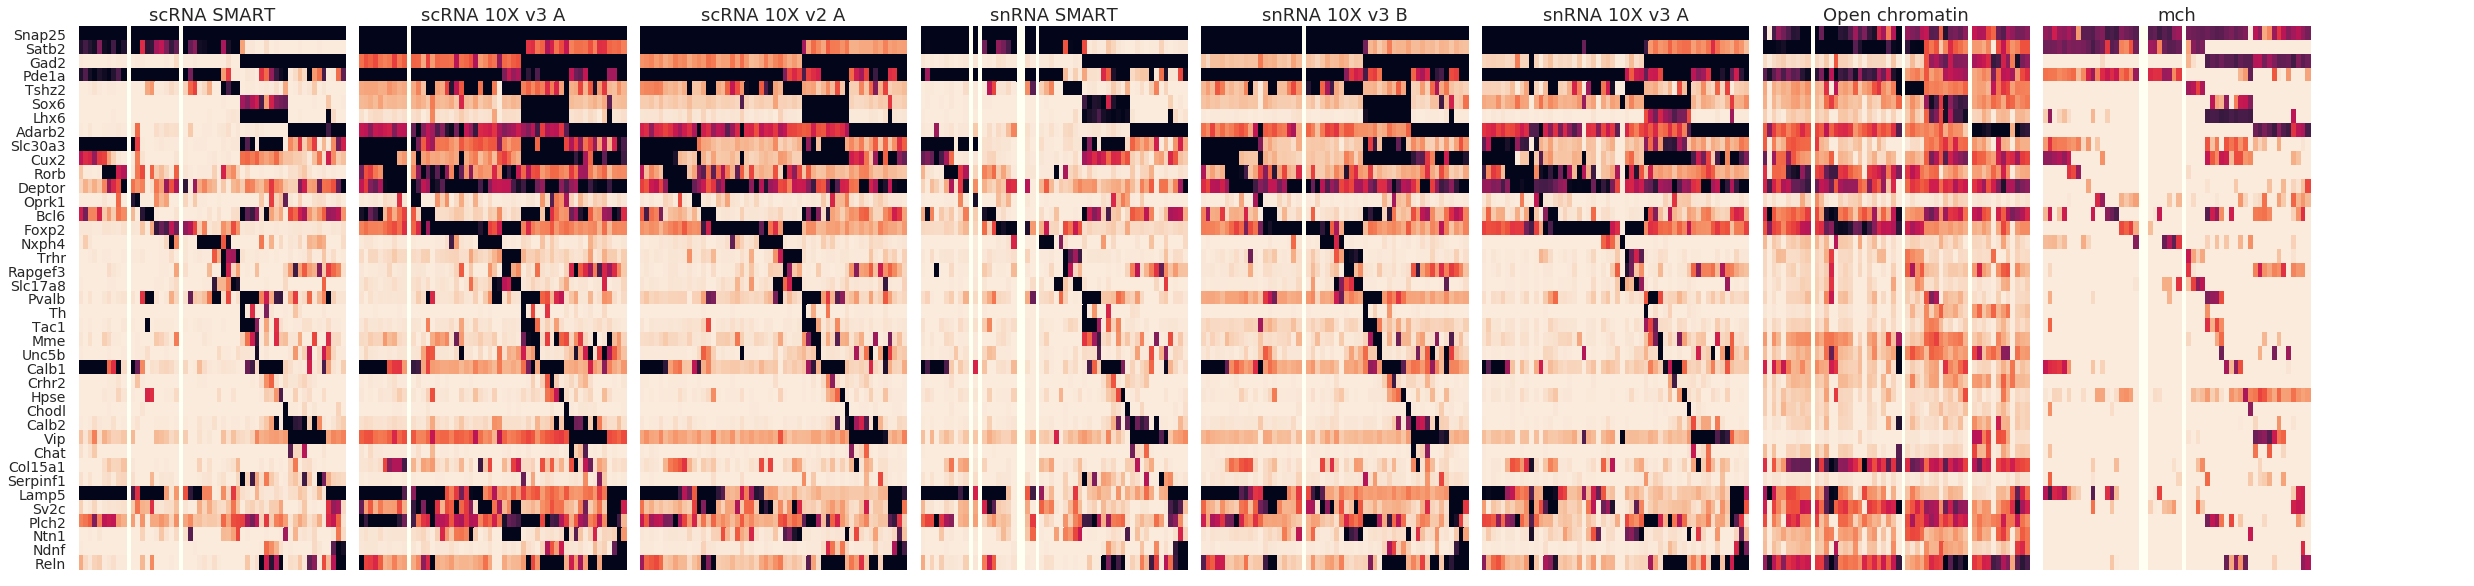

In [153]:
import scipy.cluster.hierarchy as sch
with sns.axes_style('white'):
#     n = len(mods_updated)
    n = 8
    nx = n
    ny = int((n+nx-1)/nx)
    fig, axs = plt.subplots(ny, nx, figsize=(5*nx, 10*ny))
    axs = axs.flatten()
    cbar_ax = fig.add_axes([0.9, 0.2, 0.05, 0.6])
    
    for i, (ax, mod) in enumerate(zip(axs, mods_updated)):
        if mod == 'mcg':
            continue
        if i == 0: 
            cbar = False
            
#             # row gene
#             Z = sch.linkage(df_plots[mod].fillna(0), method='average', metric='euclidean', optimal_ordering=True)
#             dn = sch.dendrogram(Z, no_plot=True)['leaves']
#             # col clst
#             Z = sch.linkage(df_plots[mod].fillna(0).T, method='average', metric='euclidean', optimal_ordering=True)
#             dn_clst = sch.dendrogram(Z, no_plot=True)['leaves']
        else:
            cbar = False
            
#         if settings[mod].mod_category == 'mc':
        if mod in ['mch', 'mcg']:
            vmin, vmax = -1, 0
        else:
            vmin, vmax = 0, 1
            
        g = sns.heatmap(df_plots[mod]
#                             .iloc[dn, dn_clst],
                            .loc[genes_inq, :]
#                             [order_joint_sch], 
#                             .iloc[dn, :]
                            [clsts_uniq], 
#                             .iloc[:, dn_clst],
                                    ax=ax, 
                                     cbar=cbar,
                                     yticklabels=True,
                                     cbar_ax=cbar_ax,
                                     cmap='rocket_r',
#                                      robust=True,
                                    vmin=vmin,
                                    vmax=vmax,
                                     )
        g.set_facecolor('#fffff2')
        if mod in ['mch', 'mcg']:
            ax.set_title(mod)
        else:
            ax.set_title('{}'.format(settings[mod].name))
        ax.set_xticks([])
        
        if i == 0:
            ax.set_yticklabels(ax.get_yticklabels(), fontsize=14)
        else:
            ax.set_yticks([])
            
        ax.set_xlabel('')
        ax.set_aspect('auto')
        
        for _, spine in ax.spines.items():
            if mod in ['mch', 'mcg']:
                spine.set_color(settings['snmcseq_gene'].color)
            else:
                spine.set_color(settings[mod].color)
            spine.set_linewidth(3)
        
    for ax in axs[n:]:
        ax.axis('off')
    cbar_ax.axis('off')
        
    
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    fig.savefig(output_figures.format('gene_heatmap', 'pdf'), bbox_inches='tight')
    plt.show()
    
# fig, ax_clst = plt.subplots(figsize=(5, 1))
# to_plot = pd.DataFrame()
# to_plot['color'] = joint_annot.loc[clsts_uniq, 'cluster_color']
# to_plot['bar'] = 1
# (to_plot['bar'].plot.bar(stacked=True, width=1, 
#                  alpha=1, 
#                   ax=ax_clst, 
#                   legend=False, 
#                  color=to_plot['color'].values, 
#                  )
# )
# ax_clst.axis('off')
# fig.savefig(output_figures.format('round3_7_gene_heatmap_cluster_color_bars_ERG_LRG', 'pdf'), bbox_inches='tight')
# plt.show()

In [101]:
output_figures.format('gene_heatmap', 'pdf')

'/cndd/fangming/CEMBA/data/MOp_all/results/figures/mop_8mods_0915_k30_gene_heatmap_2020-01-14.pdf'

In [132]:
sample_n = 1e7
genes_inq = genes_canonical

In [78]:
# clsts_uniq = np.sort(np.unique(df_info[joint_cluster]))

genes_inq = [
    'Lhx9',
#     'Fhl5',
    'Pax6',
]

gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 

df_plots = {} 
for i, mod in enumerate(mods_ordered):
    if settings[mod].mod_category == 'mc':
        for mod_update in ['mcg', 'mch']:
            gene_data = centroid_dfs[mod_update].reindex(gene_ids_inq)

            gene_data.index = genes_inq
#             gene_data = gene_data.dropna(axis=1).dropna(axis=0)
            gene_data = gene_data.dropna(axis=0)
            df_plot = gene_data
            # normalize gene_data for each row except for mC (already normalized)
#             df_plot = settings[mod].mod_direction*df_plot
            df_plots[mod_update] = df_plot.reindex(
                                            index=genes_inq, 
                                            columns=clsts_uniq,
                                            )
    else:
        gene_data = centroid_dfs[mod].reindex(gene_ids_inq)
        
        gene_data.index = genes_inq
#         gene_data = gene_data.dropna(axis=1).dropna(axis=0)
        gene_data = gene_data.dropna(axis=0)
        df_plot = gene_data
        # normalize gene_data for each row except for mC (already normalized)
#         df_plot = settings[mod].mod_direction*df_plot
#         df_plot = df_plot.divide(df_plot.max(axis=1), axis=0)
        df_plots[mod] = df_plot.reindex(
                                        index=genes_inq, 
                                        columns=clsts_uniq,
                                        )

In [50]:

# nx = len(mods_updated)
# ny = len(genes_inq)
# fig, axs = plt.subplots(ny, nx, figsize=(5*nx, 5*ny))
# # axs = axs.flatten()
# for j, gene in enumerate(genes_inq):
#     for i, mod in enumerate(mods_updated):
#         ax = axs[j,i]
#         if mod in settings.keys() and settings[mod].mod_category == 'rna':
#             ax.set_ylim([0, 1])
            
#         ax.plot(df_plots[mod].iloc[j])
        
        
#         if mod in ['mch', 'mcg']:
#             ax.set_title(mod)
#         else:
#             ax.set_title('{}'.format(settings[mod].name))
#         if i == 0:
#             ax.set_xlabel('clusters')
#             ax.set_ylabel('{}'.format(gene))
            
            
#         ax.set_aspect('auto')
    
# for ax in axs[n:]:
#     ax.axis('off')
    
# fig.tight_layout()
# # fig.savefig(output_figures.format('gene_heatmap_inconsistent', 'pdf'), bbox_inches='tight')
# plt.show()

In [51]:
# nx = len(mods_updated)
# ny = len(genes_inq)
# fig, axs = plt.subplots(ny, nx, figsize=(5*nx, 5*ny))
# # axs = axs.flatten()
# for j, gene in enumerate(genes_inq):
#     for i, mod in enumerate(mods_updated):
#         ax = axs[j,i]
#         if mod in settings.keys() and settings[mod].mod_category == 'rna':
#             ax.set_ylim([0, 1])
            
#         x = np.arange(df_plots[mod].shape[1])
#         y = df_plots[mod].iloc[j]
#         if mod in ['mch', 'mcg']:
#             color = settings['snmcseq_gene'].color
#         else:
#             color = settings[mod].color
#         ax.bar(x, y, color=color)
        
        
#         if mod in ['mch', 'mcg']:
#             ax.set_title(mod)
#         else:
#             ax.set_title('{}'.format(settings[mod].name))
#         if i == 0:
#             ax.set_xlabel('clusters')
#             ax.set_ylabel('{}'.format(gene))
#         ax.set_aspect('auto')
# for ax in axs[n:]:
#     ax.axis('off')
    
# fig.tight_layout()
# # fig.savefig(output_figures.format('gene_heatmap_inconsistent', 'pdf'), bbox_inches='tight')
# plt.show()

In [52]:
# # nx = len(mods_updated)

# with sns.axes_style('ticks'):
#     nx = 4
#     ny = len(genes_inq)
#     fig, axs = plt.subplots(ny, nx, figsize=(4*nx, 4*ny))
#     # axs = axs.flatten()
#     for j, gene in enumerate(genes_inq):
#         for i, mod in enumerate(mods_updated):
#             if mod in settings.keys() and settings[mod].mod_category == 'rna':
#                 ax = axs[j,0]
#                 ax.set_ylim([0, 1])
#             else:
#                 ax = axs[j,i-5]

#             if mod in ['mch', 'mcg']:
#                 color = settings['snmcseq_gene'].color
#             else:
#                 color = settings[mod].color
#             ax.plot(df_plots[mod].iloc[j], color=color)

#             if mod in ['mch', 'mcg']:
#                 ax.set_title(mod)
#             else:
#                 ax.set_title('{}'.format(settings[mod].name))
#             if i == 0:
#                 ax.set_xlabel('clusters')
#                 ax.set_ylabel('{}'.format(gene))


#             ax.set_aspect('auto')

#     for ax in axs[n:]:
#         ax.axis('off')

#     fig.tight_layout()
#     # fig.savefig(output_figures.format('gene_heatmap_inconsistent', 'pdf'), bbox_inches='tight')
#     plt.show()

In [53]:
[i for i, annot in enumerate(joint_annot.loc[clsts_uniq, 'annot'].values) if annot.startswith('L6b')]

[25, 26, 27, 28, 29]

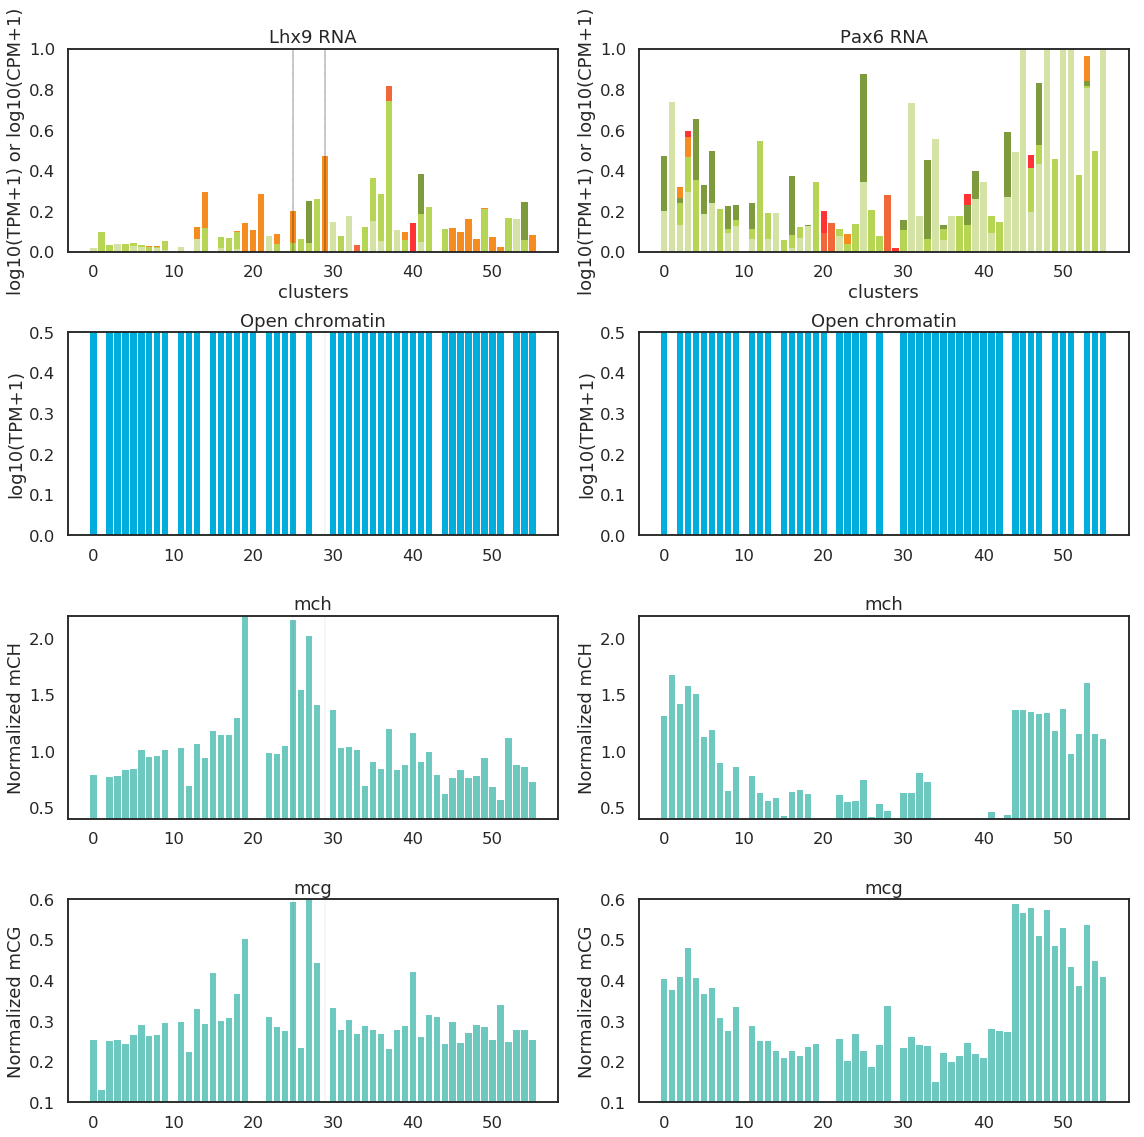

In [54]:
# nx = len(mods_updated)

# with sns.axes_style('ticks'):
with sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    nx = len(genes_inq)
    ny = 4
    fig, axs = plt.subplots(ny, nx, figsize=(8*nx, 4*ny))
    # axs = axs.flatten()
    for j, gene in enumerate(genes_inq): 
        for i, mod in enumerate(mods_updated):
            if mod in settings.keys() and settings[mod].mod_category == 'rna':
                ax = axs[0,j]
                ax.set_ylim([0, 1])
                ax.set_ylabel('log10(TPM+1) or log10(CPM+1)')
                ax.set_title('{} RNA'.format(gene))
            elif mod in settings.keys() and settings[mod].mod_category == 'atac':
                ax = axs[i-5,j]
                ax.set_ylim([0, 0.5])
                ax.set_ylabel('log10(TPM+1)')
                ax.set_title('Open chromatin')
            elif mod == 'mch':
                ax = axs[i-5,j]
                ax.set_ylim([0.4, 2.2])
                ax.set_ylabel('Normalized mCH')
                ax.set_title(mod)
            elif mod == 'mcg':
                ax = axs[i-5,j]
                ax.set_ylim([0.1, 0.6])
                ax.set_ylabel('Normalized mCG')
                ax.set_title(mod)

            if mod in ['mch', 'mcg']:
                color = settings['snmcseq_gene'].color
            else:
                color = settings[mod].color
                
            if gene == 'Lhx9':
                
                ax.axvline(25, linewidth=0.1, linestyle='--', color='black')
                ax.axvline(29, linewidth=0.1, linestyle='--', color='black')
            
            x = np.arange(df_plots[mod].shape[1])
            y = df_plots[mod].iloc[j]
            ax.bar(x, y, color=color)
            

            if i == 0:
                ax.set_xlabel('clusters')
                ax.set_ylabel('{}'.format(gene))


            ax.set_aspect('auto')

    for ax in axs[n:]:
        ax.axis('off')

    fig.tight_layout()
    # fig.savefig(output_figures.format('gene_heatmap_inconsistent', 'pdf'), bbox_inches='tight')
    plt.show()

In [55]:
clsts_manual_order = collections.OrderedDict({
 '4-1': 'L2/3 IT ',
 '4-2': 'L2/3 IT ',
 '1-1': 'L5 IT Rspo1_1',
 '1-2': 'L5 IT Rspo2_1',
 '3-2': 'L5 IT S100b',
 '3-1': 'L6 IT_2',
 '3-3': 'L6 IT Car3',
    
 '9-1': 'L5 ET_1',
 '9-2': 'L5 ET_2',
    
 '2-1': 'L6 CT Cpa6',
 '2-2': 'L6 CT Cpa6',
 '2-3': 'L6 CT Nxph2 Pou3f2',
    
 '8-1': 'L6b Shisa6_1',
 '8-2': 'L6b Ror1',
 '8-3': 'L6b Kcnip1_2',
    
 '7-1': 'L6 NP Trh_1',
 '7-2': 'L5 NP Slc17a8',
    
 '5-1': 'Pvalb Reln',
 '5-4': 'Pvalb Gabrg1',
 '5-5': 'Pvalb Vipr2',
    
 '5-2': 'Sst Myh8_2',
 '5-3': 'Sst Calb2',
 '10-1': 'Sst Chodl',
    
 '6-1': 'Vip Chat',
 '6-3': 'Vip Igfbp6',
 '6-5': 'Sncg Col14a1',
    
 '6-2': 'Lamp5 Slc35d3',
 '6-4': 'Lamp5 Pdlim5',
 '6-6': 'Lamp5 Lhx6',
})


clsts_uniq = np.array(list(clsts_manual_order.keys()))

In [56]:
centroid_dfs['smarter_cells']
centroid_dfs_round2 = {}
for mod in mods_updated:
    print(mod)
    centroid_dfs[mod]

smarter_cells
10x_cells_v3
10x_cells_v2
smarter_nuclei
10x_nuclei_v3_macosko
10x_nuclei_v3
snatac_gene
mch
mcg


In [57]:
f_format = '/cndd2/fangming/miniatlas/cluster_level/gene_features_{}_round2.tsv'
centroid_dfs = {}
for mod in mods_selected:
    print(mod)
    if settings[mod].mod_category == 'mc':
        for mod_update in ['mcg', 'mch']:
            f = f_out_format.format(mod_update)
            centroid_dfs[mod_update] = pd.read_csv(f, sep='\t', index_col=0)
    else:
        f = f_out_format.format(mod)
        centroid_dfs[mod] = pd.read_csv(f, sep='\t', index_col=0)
    
print(centroid_dfs.keys())
    

snmcseq_gene


NameError: name 'f_out_format' is not defined

In [58]:
for key, item in centroid_dfs.items():
    print(key, item.shape)

In [59]:
# clsts_uniq = np.sort(np.unique(df_info[joint_cluster]))

genes_inq = [
    'Lhx9',
#     'Fhl5',
    'Pax6',
]

gene_ids_inq = df_genes_v2.reindex(genes_inq)['gene_id_abbr'].values 

df_plots = {} 
for i, mod in enumerate(mods_ordered):
    if settings[mod].mod_category == 'mc':
        for mod_update in ['mcg', 'mch']:
            gene_data = centroid_dfs[mod_update].reindex(gene_ids_inq)

            gene_data.index = genes_inq
            gene_data = gene_data.dropna()
            df_plot = gene_data
            # normalize gene_data for each row except for mC (already normalized)
#             df_plot = settings[mod].mod_direction*df_plot
            df_plots[mod_update] = df_plot.reindex(
                                            index=genes_inq, 
                                            columns=clsts_uniq,
                                            )
    else:
        gene_data = centroid_dfs[mod].reindex(gene_ids_inq)
        
        gene_data.index = genes_inq
        gene_data = gene_data.dropna()
        df_plot = gene_data
        # normalize gene_data for each row except for mC (already normalized)
#         df_plot = settings[mod].mod_direction*df_plot
#         df_plot = df_plot.divide(df_plot.max(axis=1), axis=0)
        df_plots[mod] = df_plot.reindex(
                                        index=genes_inq, 
                                        columns=clsts_uniq,
                                        )

KeyError: 'snatac_gene'

In [60]:
[i for i, (key, val) in enumerate(clsts_manual_order.items()) if val.startswith('L6b')]

[12, 13, 14]

KeyError: 'smarter_cells'

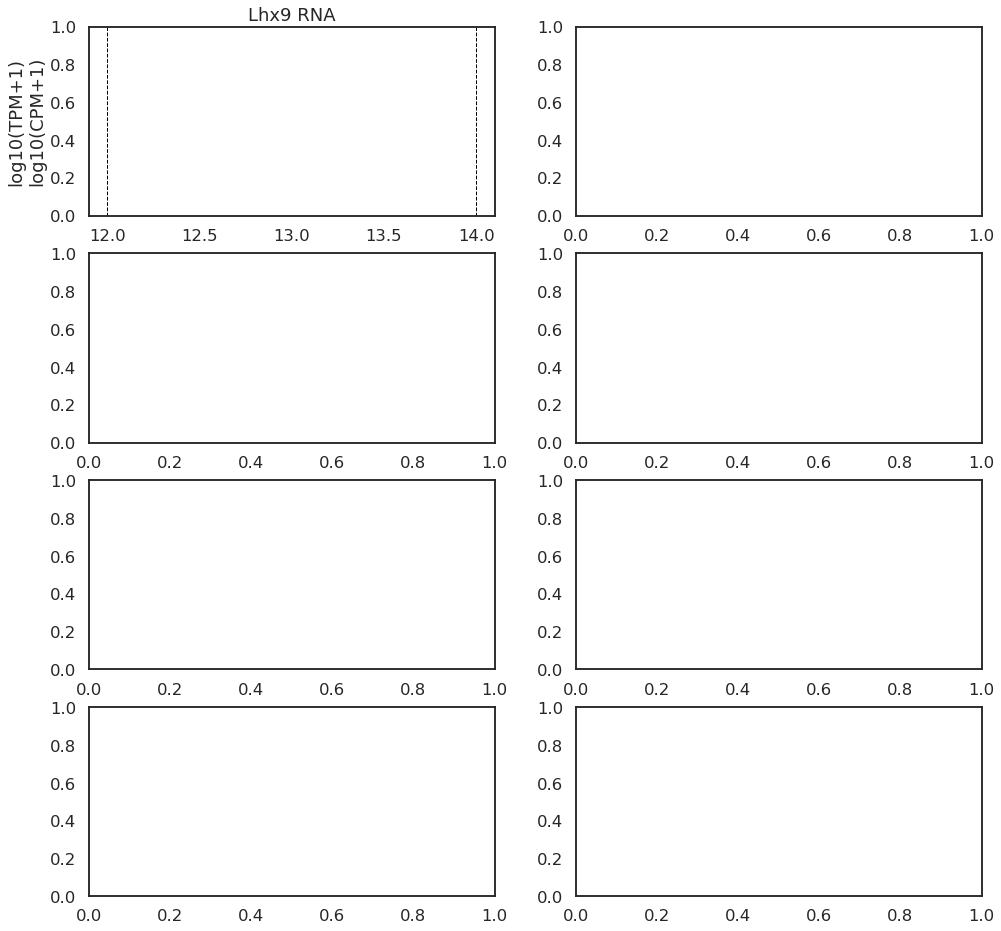

In [61]:
# nx = len(mods_updated)

# with sns.axes_style('ticks'):
with sns.axes_style('white', {"patch.edgecolor": "black", 'patch.force_edgecolor': False,}):
    nx = len(genes_inq)
    ny = 4
    fig, axs = plt.subplots(ny, nx, figsize=(8*nx, 4*ny))
    # axs = axs.flatten()
    for j, gene in enumerate(genes_inq): 
        for i, mod in enumerate(mods_updated):
            if mod in settings.keys() and settings[mod].mod_category == 'rna':
                ax = axs[0,j]
                ax.set_ylim([0, 1])
                ax.set_ylabel('log10(TPM+1)\nlog10(CPM+1)')
                ax.set_title('{} RNA'.format(gene))
            elif mod in settings.keys() and settings[mod].mod_category == 'atac':
                ax = axs[i-5,j]
                ax.set_ylim([0, 0.4])
                ax.set_ylabel('log10(TPM+1)')
                ax.set_title('Open chromatin')
            elif mod == 'mch':
                ax = axs[i-5,j]
                ax.set_ylim([0.4, 2.5])
                ax.set_ylabel('Normalized mCH')
                ax.set_title(mod)
            elif mod == 'mcg':
                ax = axs[i-5,j]
                ax.set_ylim([0.1, 0.7])
                ax.set_ylabel('Normalized mCG')
                ax.set_title(mod)

            if mod in ['mch', 'mcg']:
                color = settings['snmcseq_gene'].color
            else:
                color = settings[mod].color
                
            if gene == 'Lhx9':
                
                ax.axvline(12, linewidth=1, linestyle='--', color='black')
                ax.axvline(14, linewidth=1, linestyle='--', color='black')
            
            x = np.arange(df_plots[mod].shape[1])
            y = df_plots[mod].iloc[j]
            ax.bar(x, y, color=color)
            

            if i == 9-1:
                ax.set_xticks(x)
                ax.set_xticklabels([val for key, val in clsts_manual_order.items()], rotation=90, fontsize=10)
                ax.set_xlabel('clusters')

            ax.set_aspect('auto')
    fig.tight_layout()
    fig.savefig(output_figures.format('barplot_Lhx9', 'pdf'), bbox_inches='tight')
    plt.show()